## EvadeGANx ##


In [ ]:
# Data & Classifier Imports
import time
import random
import scipy as sp
import pandas as pd
import numpy as np
from numpy import ones, zeros
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from src.data import Data
from src.features import get_features, plot_features
from src.classifier import fit_clf, evaluate

# Attacker imports
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.sparse import SparseTensor
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers import ActivityRegularization, Dropout
from keras.layers.merge import Maximum, Concatenate, Multiply
from keras.models import Model, load_model
from keras.optimizers import Adam, Nadam, Adagrad
from keras.regularizers import l1, l2, l1_l2
from keras.losses import binary_crossentropy
from keras.utils.vis_utils import plot_model
from src.attack import EvadeGAN, binarise
from src.attack import output_progress, plot_TPR_metrics, plot_confusion_matrix
from IPython.core.debugger import set_trace
from IPython.display import display, HTML, Image

%matplotlib inline
%load_ext autoreload

Main directories

In [ ]:
TOP_DIR = './data/'
PLOT_DIR = TOP_DIR + 'plots/'
ADV_DIR = PLOT_DIR + 'adversarial/'
TPR_DIR = PLOT_DIR + 'TPR/'
GAN_DIR  = TOP_DIR + 'GAN/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fix the random seeds for reproducibility

In [ ]:
# Fix the random seeds for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print("\u0044\u006f\u006e\u0065\u0020\u2713")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **1. Load & Split the Dataset**

**Feature selection** based on the $ \chi^2 $ test to pick the top 10K features that are most correlated with class labels _(most discriminative between the two classes)._

In [ ]:
# Class labels, could change them with WGAN
MAL_LABEL = 1
GOOD_LABEL = 0

n_features = 10000

# Load data
%autoreload
data = Data(n_features=n_features)

# Split data
X_train, X_test, Y_train, Y_test = data.split(test_size=0.3, random_state=0)

# Adjust Class Labels [Goodware is 0 or -1]
Y_train[Y_train == 0] = GOOD_LABEL
Y_test[Y_test == 0] = GOOD_LABEL
Y_train[Y_train == 1] = MAL_LABEL
Y_train[Y_train == 1] = MAL_LABEL

# Malware & its split subsets
X_malware = data.get_X_malware()
X_mal_train = data.get_X_mal_train()
X_mal_test = data.get_X_mal_test()

# Goodware & its split subsets
X_goodware = data.get_X_goodware()
X_good_train = data.get_X_good_train()
X_good_test = data.get_X_good_test()


Starting to read the data shelf
Finished reading the data shelf. Elapsed time: 0.002672796166674137 minutes


### **2. Fit the Classifier (Target Model)**

In [ ]:
# Fit the classifier
model = fit_clf(X_train, Y_train, C=1.0, weight={1:2, 0:1}, linearsvc=True,
                fname=f'c_1_top_{n_features}_test_0.3_weight_2_linearsvc')

Model c_1_top_10000_test_0.3_weight_2_linearsvc Loaded


In [ ]:
# Get model parameters (either LinearSVC or SVC)
C = model.C
if type(model)==LinearSVC:
    weights = model.coef_.flatten()
elif type(model)==SVC:
    weights = model.coef_.toarray().flatten()
intercept = model.intercept_[0]
print("C =", C)
print("Weights =", np.round(weights,4))
print(f"Non-zero Weights % = "
      f"{100*np.nonzero(weights)[0].shape[0]/weights.shape[0]:.2f}%")
print("Intercept =", intercept)

C = 1.0
Weights = [-0.      0.4176  0.1756 ...  0.      0.      0.    ]
Non-zero Weights % = 77.28%
Intercept = -1.308508950646257


**Feature weights** (insight into the model **complexity**  and
**interpretability**)

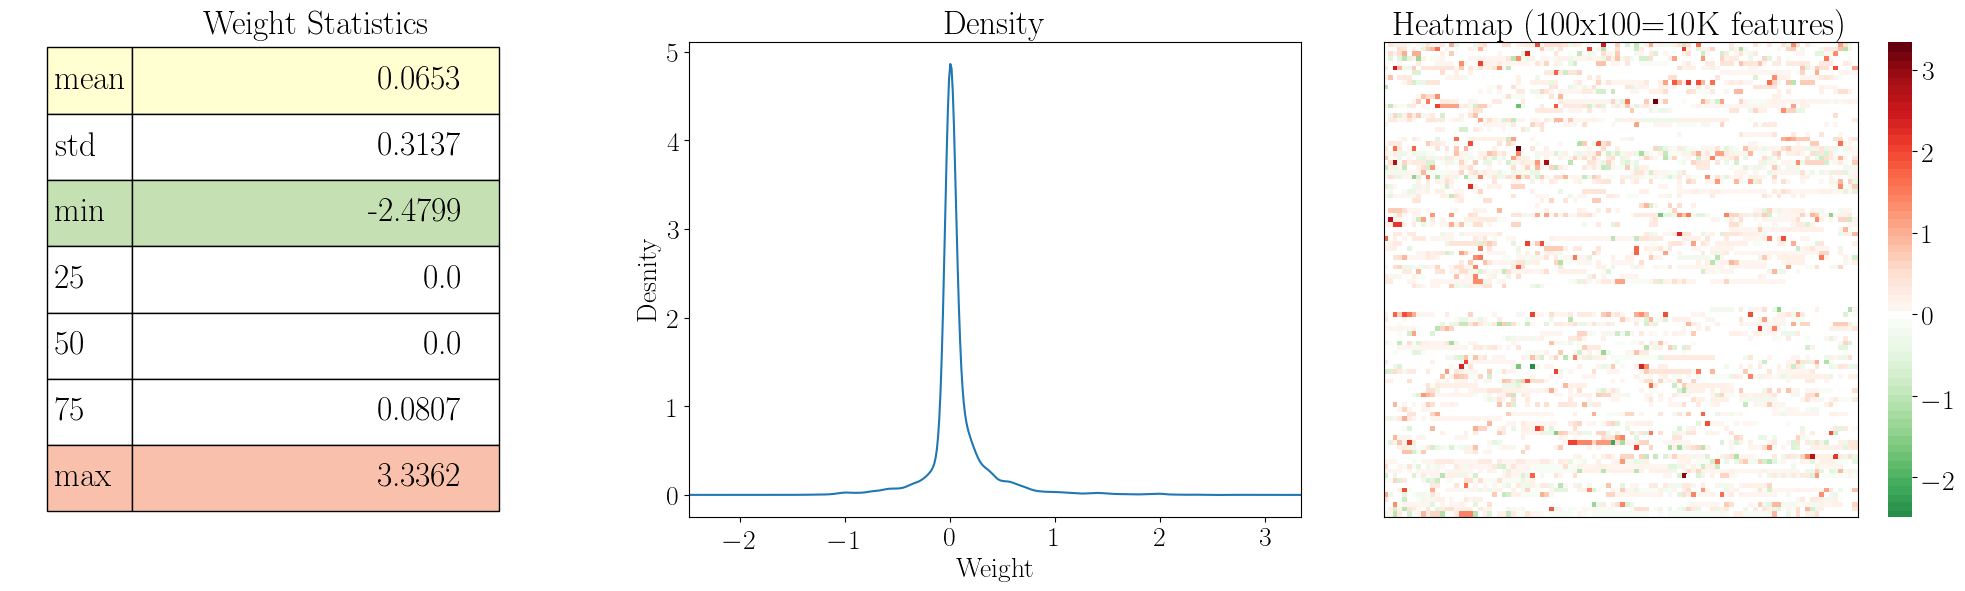

In [ ]:
%autoreload

plot_features(model)

### **3. Label the Data using the Target Model**

In [ ]:
print("TP (Malware) [True Positives, from each of the training & test sets]\n"
      "====================================================================")

# From the training set
# From the training set
Y_pred = model.predict(X_mal_train)
TP_train = X_mal_train[np.where(Y_pred==MAL_LABEL)[0]]
print(f'All mal_train: {X_mal_train.shape[0]}')
print(f'TP_train: {TP_train.shape[0]} '
      f'({100*TP_train.shape[0]/X_mal_train.shape[0]:.2f}%)\n')

# From the test set
Y_pred = model.predict(X_mal_test)
TP_test = X_mal_test[np.where(Y_pred==MAL_LABEL)[0]]
print(f'All mal_test: {X_mal_test.shape[0]}')
print(f'TP_test: {TP_test.shape[0]} '
      f'({100*TP_test.shape[0]/X_mal_test.shape[0]:.2f}%)')

TP (Malware) [True Positives, from each of the training & test sets]
All mal_train: 8914
TP_train: 8385 (94.07%)

All mal_test: 3821
TP_test: 3451 (90.32%)


In [ ]:
print("TN (Goodware) [True Negatives, from each of the training & test sets]\n"
      "=====================================================================")

# From the training set
Y_pred = model.predict(X_good_train)
TN_train = X_good_train[np.where(Y_pred==GOOD_LABEL)[0]]
print(f'All good_train: {X_good_train.shape[0]}')
print(f'TN_train: {TN_train.shape[0]} '
      f'({100*TN_train.shape[0]/X_good_train.shape[0]:.2f}%)\n')

# From the test set
Y_pred = model.predict(X_good_test)
TN_test = X_good_test[np.where(Y_pred==GOOD_LABEL)[0]]
print(f'All good_test: {X_good_test.shape[0]}')
print(f'TN_test: {TN_test.shape[0]} '
      f'({100*TN_test.shape[0]/X_good_test.shape[0]:.2f}%)')

TN (Goodware) [True Negatives, from each of the training & test sets]
All good_train: 81895
TN_train: 81359 (99.35%)

All good_test: 35098
TN_test: 34758 (99.03%)


### Training & Test Sets for **EvadeGAN**
**EvadeGAN** shares the same training and test data as the target model,
but **only those correctly classified by the target model** are considered.


In [ ]:
# Will only consider TP Malware
X_mal_train = TP_train.todense()
X_mal_test = TP_test.todense()

# Will only consider TN Goodware
X_good_train = TN_train.todense()
X_good_test = TN_test.todense()

print("All Dense!")

All Dense!


### **4. Attack ⚡**

#### Training and Model Hyperparameters

In [ ]:
################################################################################
# EvadeGAN Mode
################################################################################
g_input = 'x'              # {'x', 'z', 'xz'}
################################################################################


# All dimensions
x_dim = n_features          # 10000
z_dim = 100                 # 32, 64, 128, 256, 512, 1024
n_hidden = 256
################################################################################
# Loss hyperparameters
targetEvasionRate = 1.0     # 100% (TPR=0.0)
alpha = 0.0015              # Weight for sparsity penalty (L1 regularisation)
beta = 10000                # Weight for the upper bound penalty (hinge loss)
normalise_loss = True       # Whether to scale loss to the range [0, 1]
max_changes = 15            # Upper bound for changes
bound_reduce_func = 'mean'  # function to reduce batch changes, 'mean' or 'max' 
                            # 'max' is (more restrictive)
################################################################################
bin_threshold = 0.5           # Binarisation threshold


# Parameters for building the generator
g_params = {'n_hidden': n_hidden,
            'h_activation': 'relu', 'batchnorm':False,
            'regularizers': {'activity_regularizer':l1_l2(alpha, 5e-5)},
            'out_activation': 'sigmoid',
            'drop_rate': 0.5}


# Parameters for building the discriminator
d_params = {'n_hidden': n_hidden,
            'h_activation': 'linear',
            'h_constraint': None,
            'out_activation': 'sigmoid'}

# Parameters for compiling the discriminator (learining parameters)
d_compile_params = {'loss': 'binary_crossentropy',
                    'optimizer': Nadam(lr=0.001, clipvalue=1.0),
                    'metrics': ['accuracy']}


gan_compile_params = {'loss': 'custom',
                      'beta':beta, 'normalise_loss':normalise_loss,
                      'bound_func':bound_reduce_func, 'target_label':GOOD_LABEL,
                      'max_changes':max_changes,
                      'optimizer': Nadam(lr=0.0005, clipvalue=1.0),
                      'metrics': ['accuracy']}

# Sample-Dependent Pertubations XZ
evadeGAN = EvadeGAN(target_model=model, x_dim=x_dim, z_dim=z_dim,
                    g_input=g_input,
                    bin_threshold = bin_threshold,
                    g_params=g_params, d_params=d_params, 
                    d_compile_params=d_compile_params, 
                   gan_compile_params=gan_compile_params)


In [ ]:
%autoreload

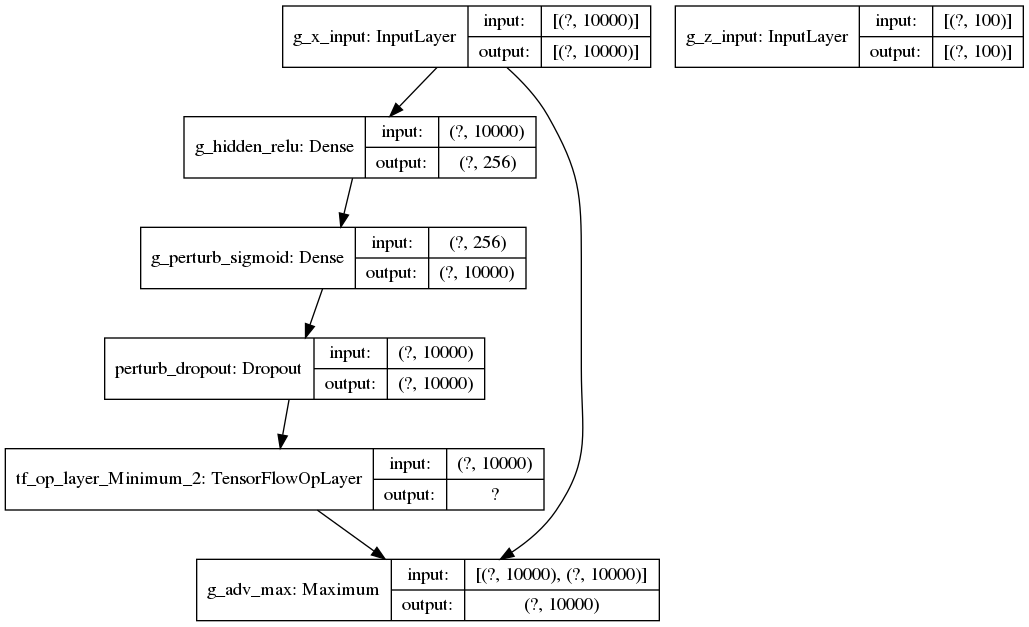

In [ ]:
plot_model(evadeGAN.generator, to_file="evadeGAN_gen.png", show_shapes=True,
           show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)
display(HTML("<h3>EvadeGAN Generator</h3><br />"))
Image("evadeGAN_gen.png")


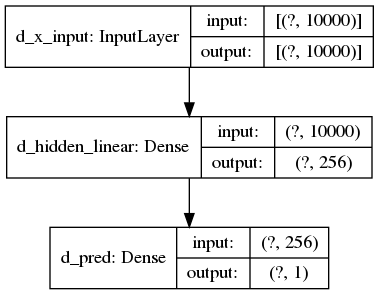

In [ ]:
plot_model(evadeGAN.discriminator, to_file="evadeGAN_dis.png", show_shapes=True,
           show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)
display(HTML("<h3>EvadeGAN Discriminator</h3><br />"))
Image("evadeGAN_dis.png")

### **4.1 EvadeGAN Training**

Training for 100 epochs.
**Best performance** achieved after **53 epochs**, with **evasion rate = 100%**
and **avg 11.3 changes per sample**.

Initial TPR on the training set: [1.0]
Initial TPR on the test set: [1.0]


>>>> New Best Results: Previous minTPR: [1.00000000] ==> New minTPR: [0.00202840] GAN Loss: [593.83913991]  <<<<
Epoch: 0
TPR Training : 0.00083482 | Avg # Changes: 64 ± SD(5.70) |  Change Quantiles (25%, 50%, 75%): [60, 63, 67] | Max 82
TPR Testing  : 0.00202840 | Avg # Changes: 64 ± SD(5.74) |  Change Quantiles (25%, 50%, 75%): [60, 64, 67] | Max: 80



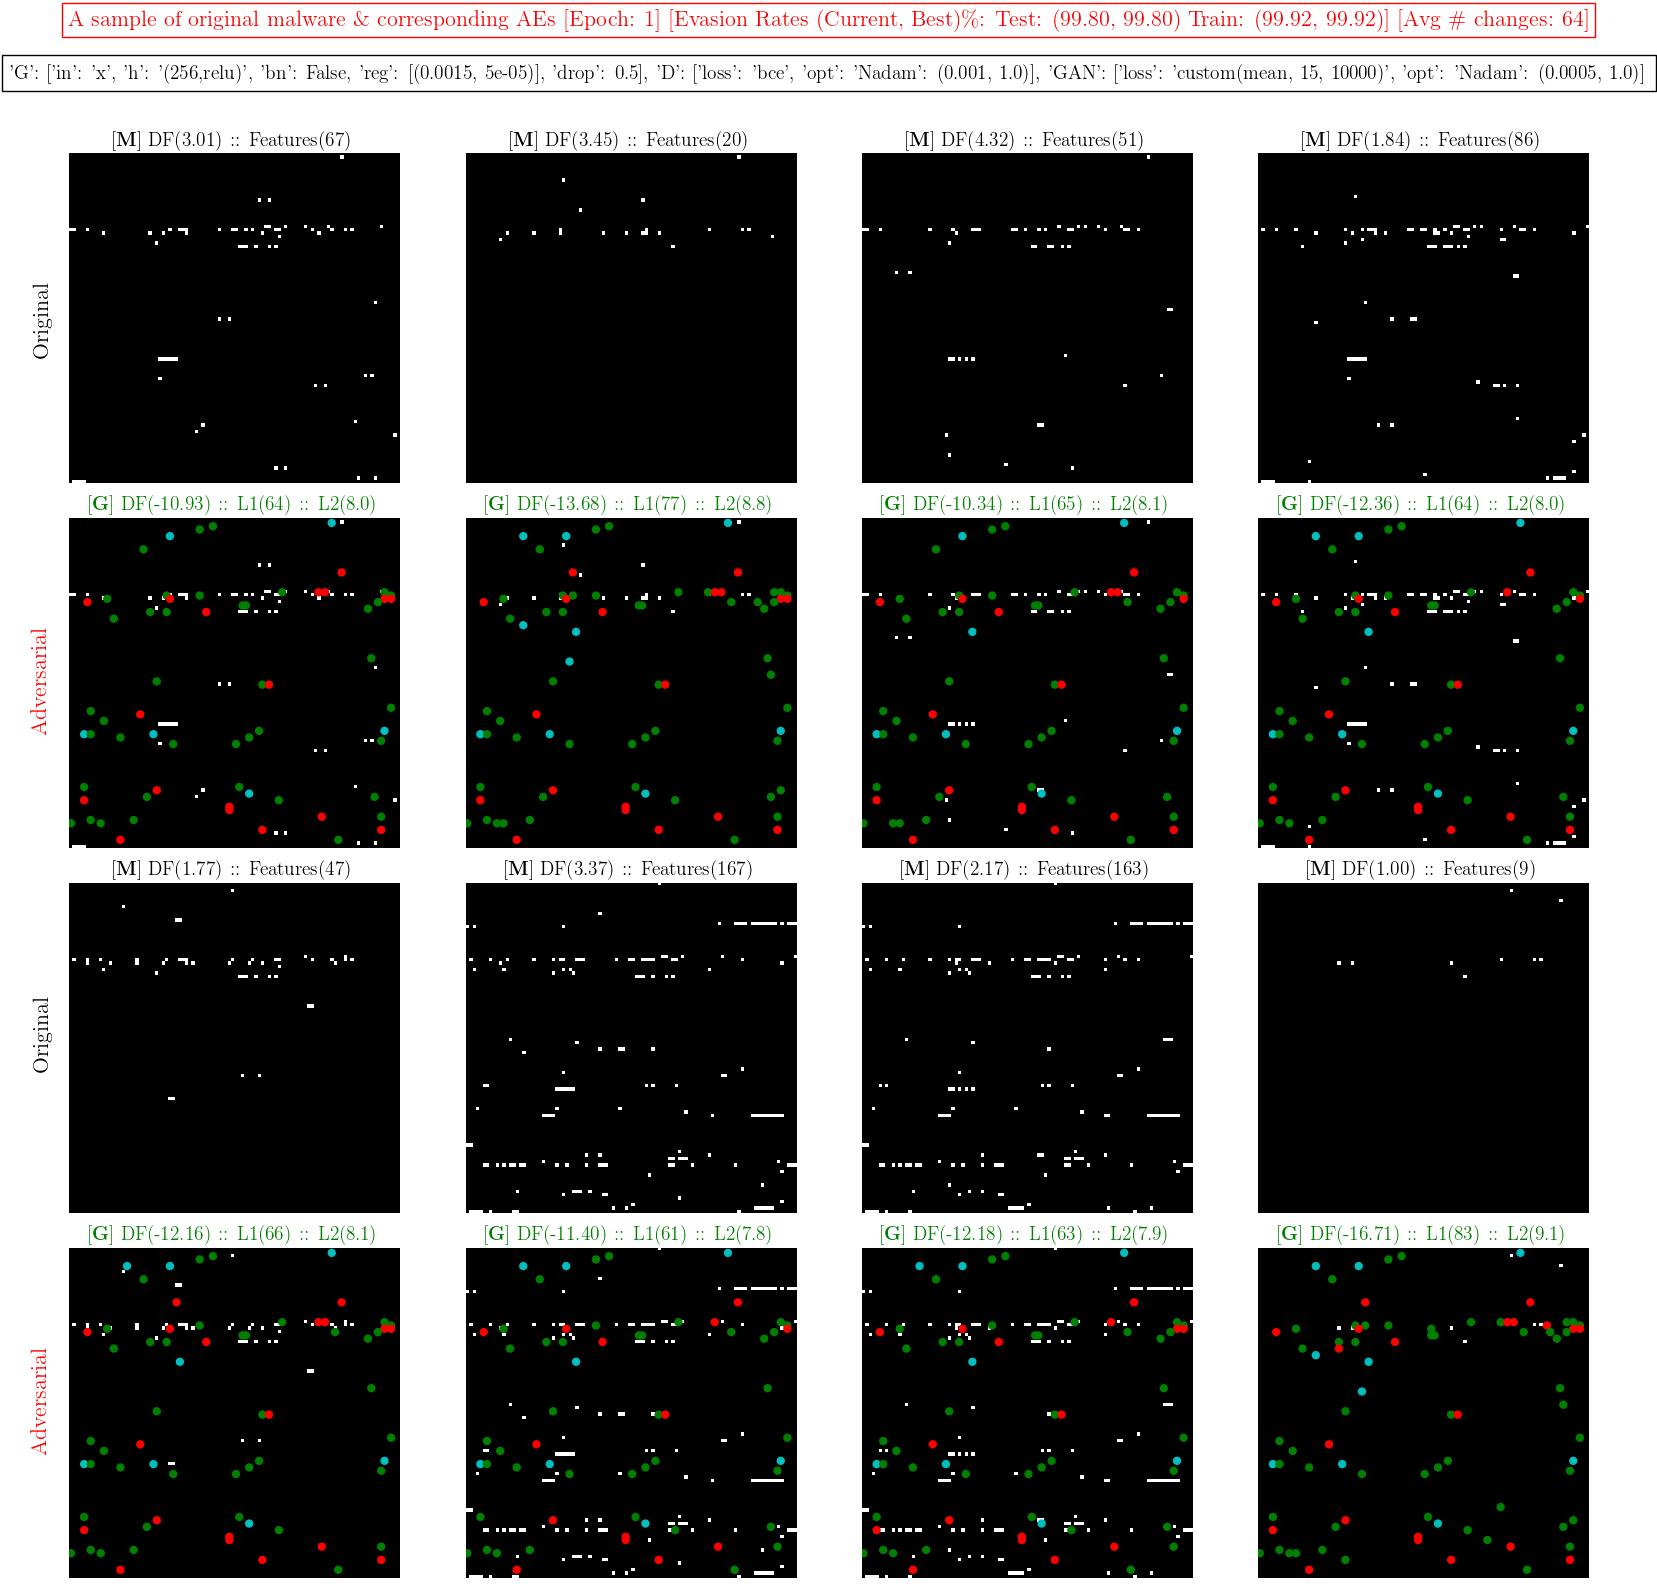


>>>> New Best Results: Previous minTPR: [0.00202840] ==> New minTPR: [0.00000000] GAN Loss: [21.76867940]  <<<<
Epoch: 2
TPR Training : 0.00000000 | Avg # Changes: 50 ± SD(2.00) |  Change Quantiles (25%, 50%, 75%): [49, 50, 51] | Max 63
TPR Testing  : 0.00000000 | Avg # Changes: 50 ± SD(1.87) |  Change Quantiles (25%, 50%, 75%): [49, 50, 51] | Max: 63



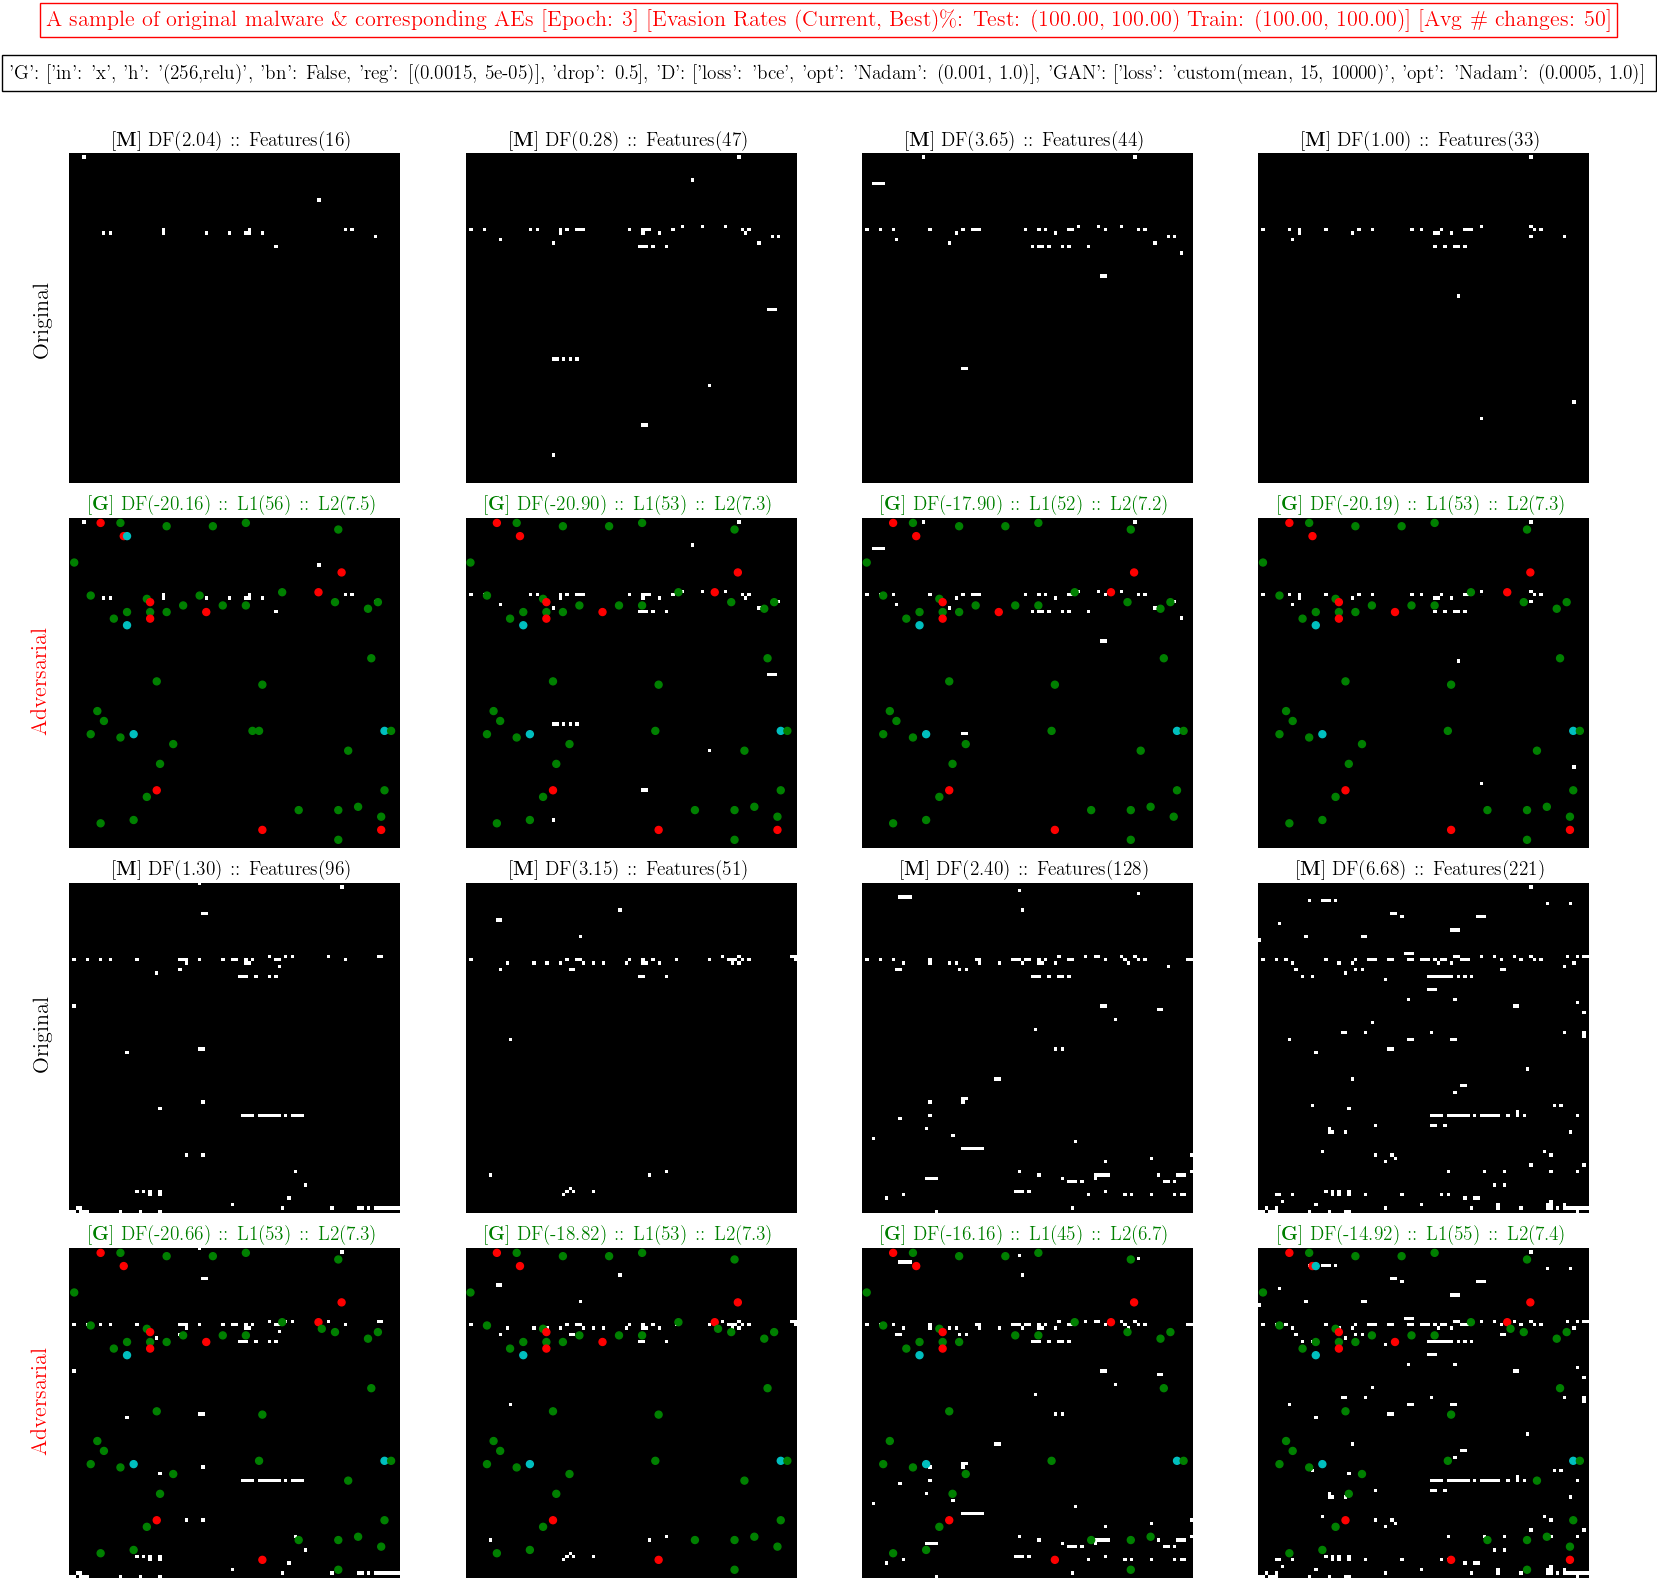


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [2] epochs, with avg 49.9 and max 63.0 changes per sample (on the test set) ... GAN Loss: [21.76867940]
######################################################################################################################################################


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [15.89845962]  <<<<
Epoch: 7
TPR Training : 0.00000000 | Avg # Changes: 33 ± SD(7.00) |  Change Quantiles (25%, 50%, 75%): [30, 31, 33] | Max 129
TPR Testing  : 0.00000000 | Avg # Changes: 33 ± SD(6.89) |  Change Quantiles (25%, 50%, 75%): [30, 31, 33] | Max: 101



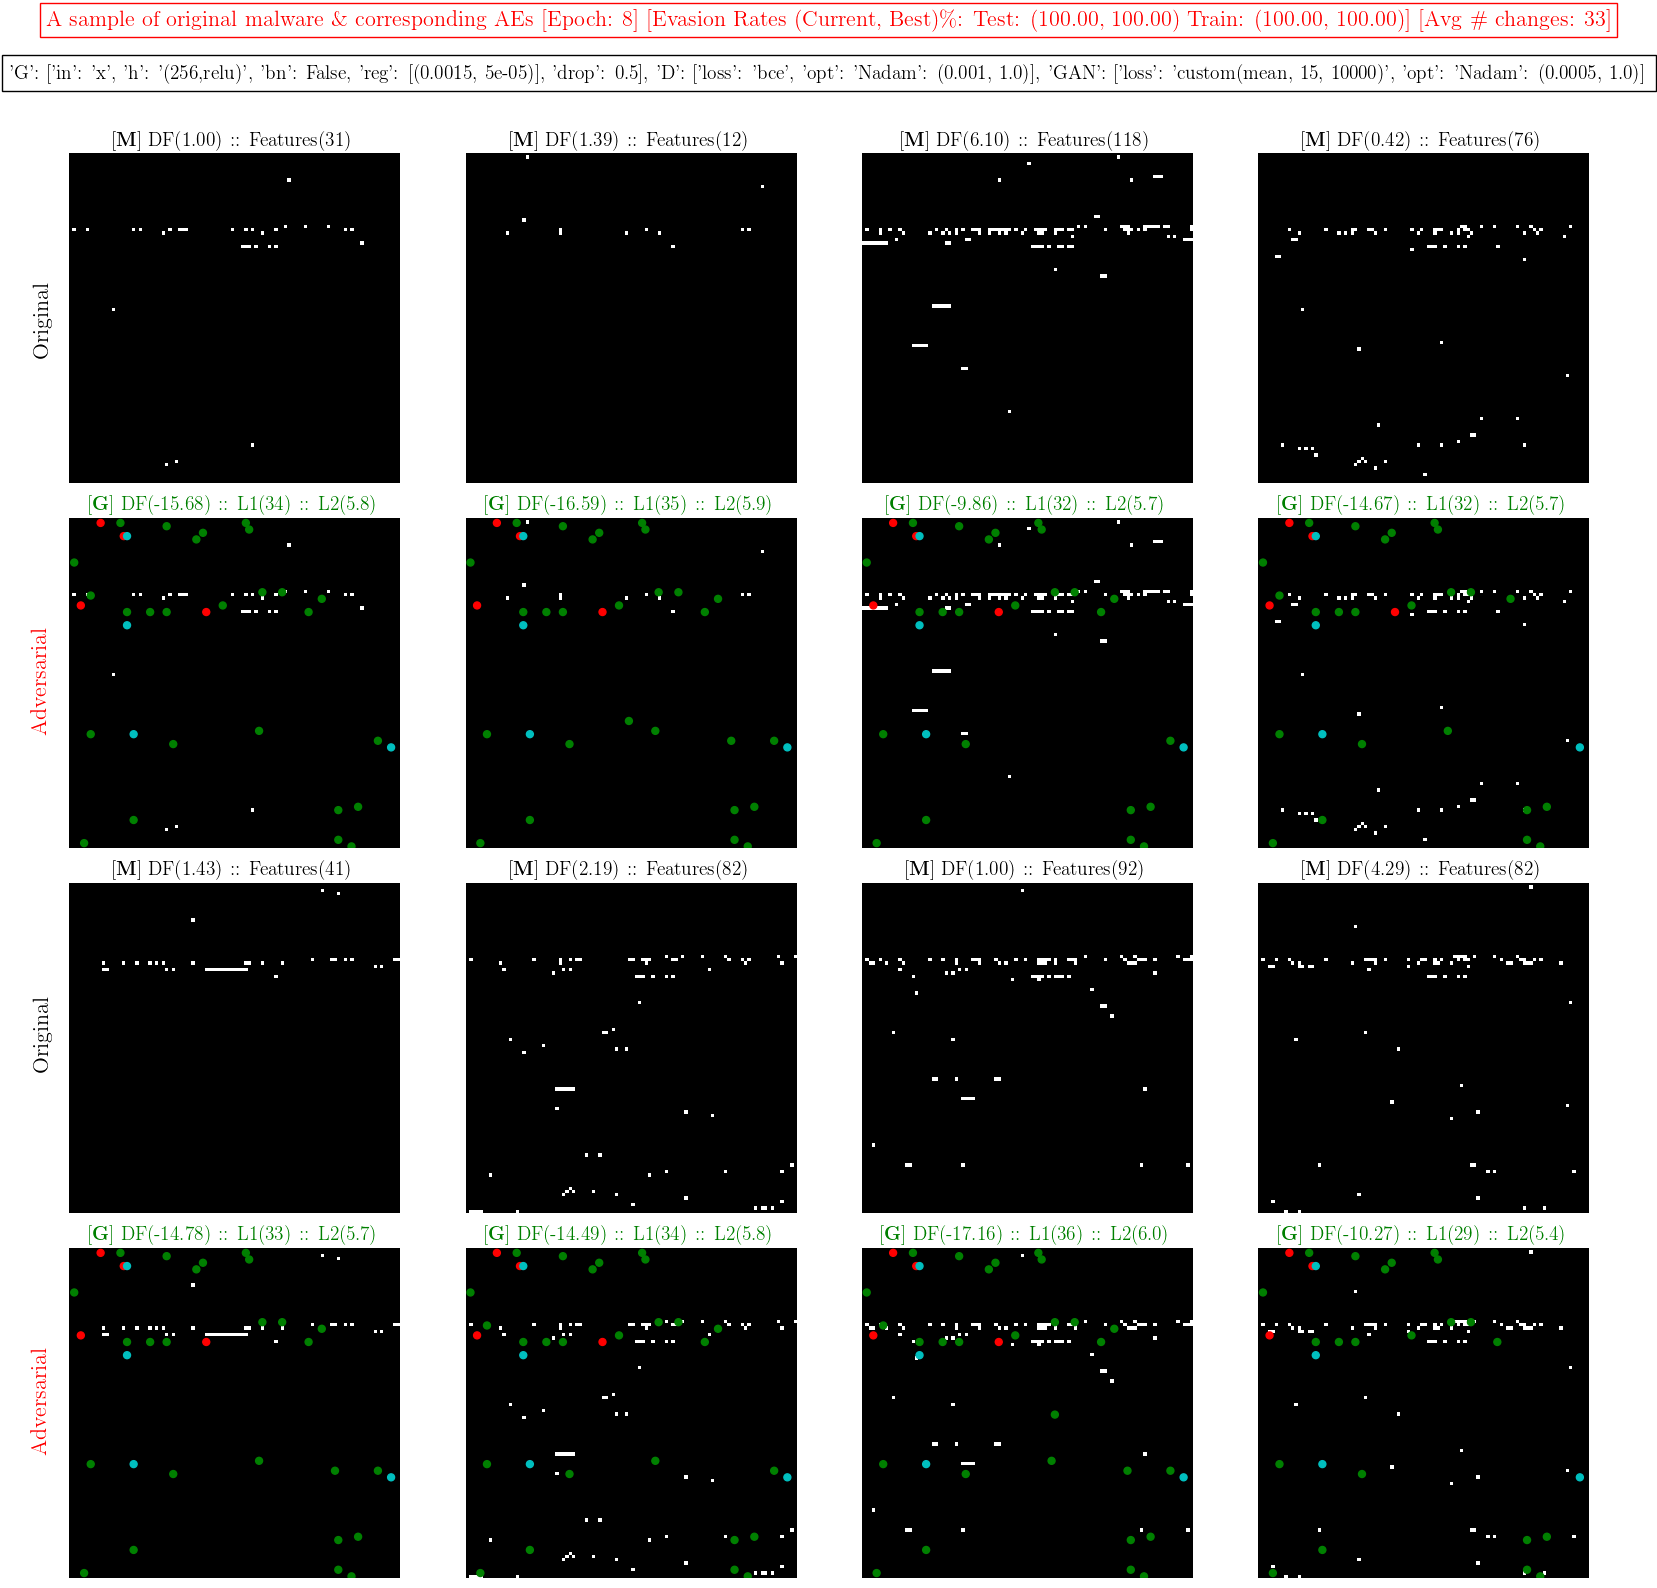


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [7] epochs, with avg 32.7 and max 101.0 changes per sample (on the test set) ... GAN Loss: [15.89845962]
######################################################################################################################################################


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [13.13196791]  <<<<
Epoch: 8
TPR Training : 0.00000000 | Avg # Changes: 29 ± SD(6.75) |  Change Quantiles (25%, 50%, 75%): [26, 28, 31] | Max 166
TPR Testing  : 0.00000000 | Avg # Changes: 29 ± SD(6.46) |  Change Quantiles (25%, 50%, 75%): [26, 28, 31] | Max: 116



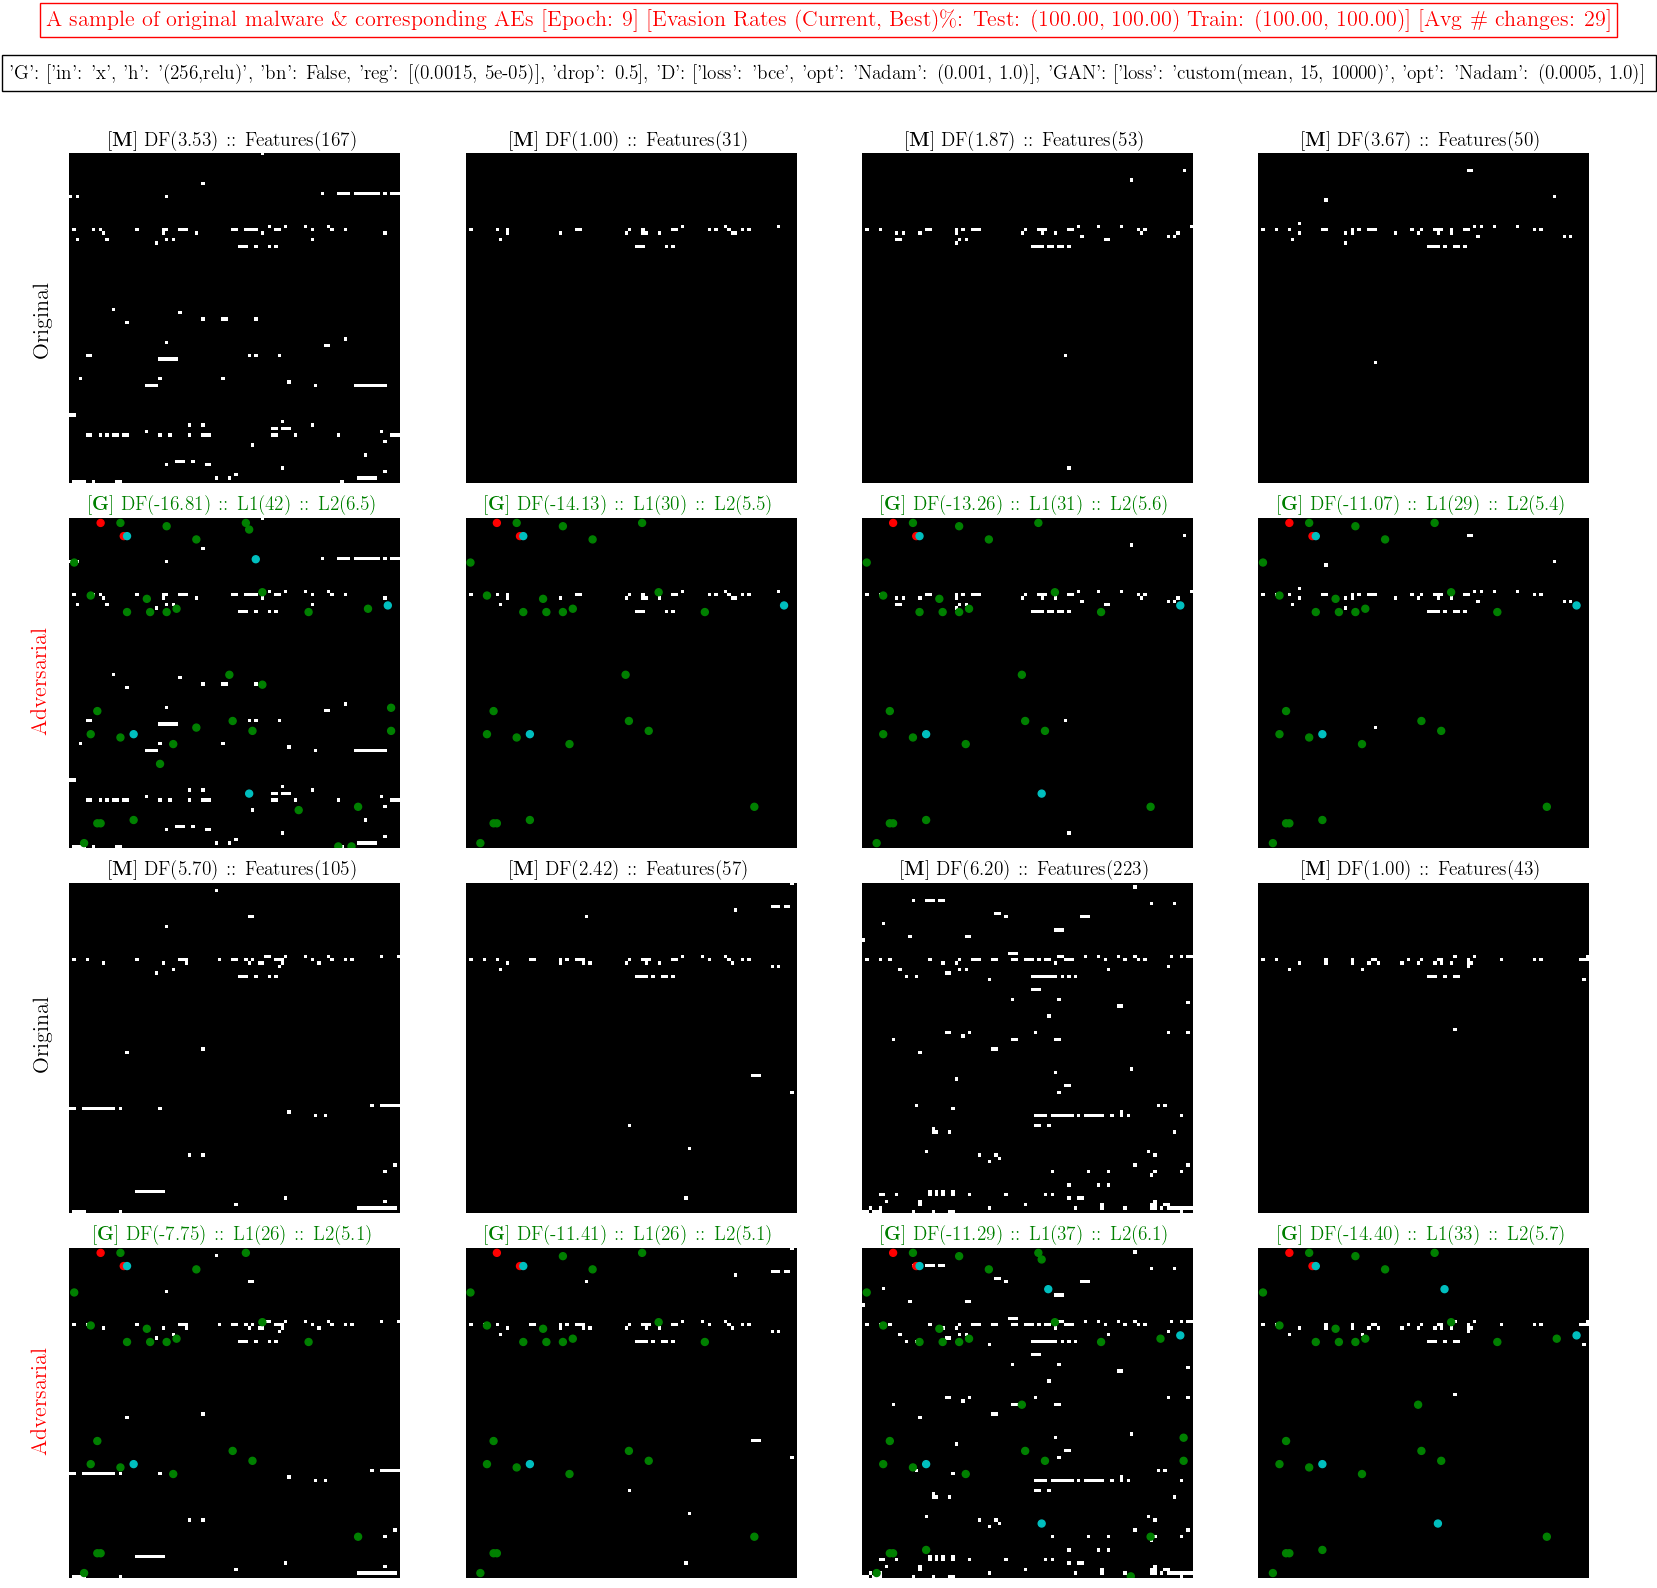


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [8] epochs, with avg 29.4 and max 116.0 changes per sample (on the test set) ... GAN Loss: [13.13196791]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [10] epochs, with avg 30.7 and max 119.0 changes per sample (on the test set) ... GAN Loss: [10.25762892]
######################################################################################################################################################



>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] G

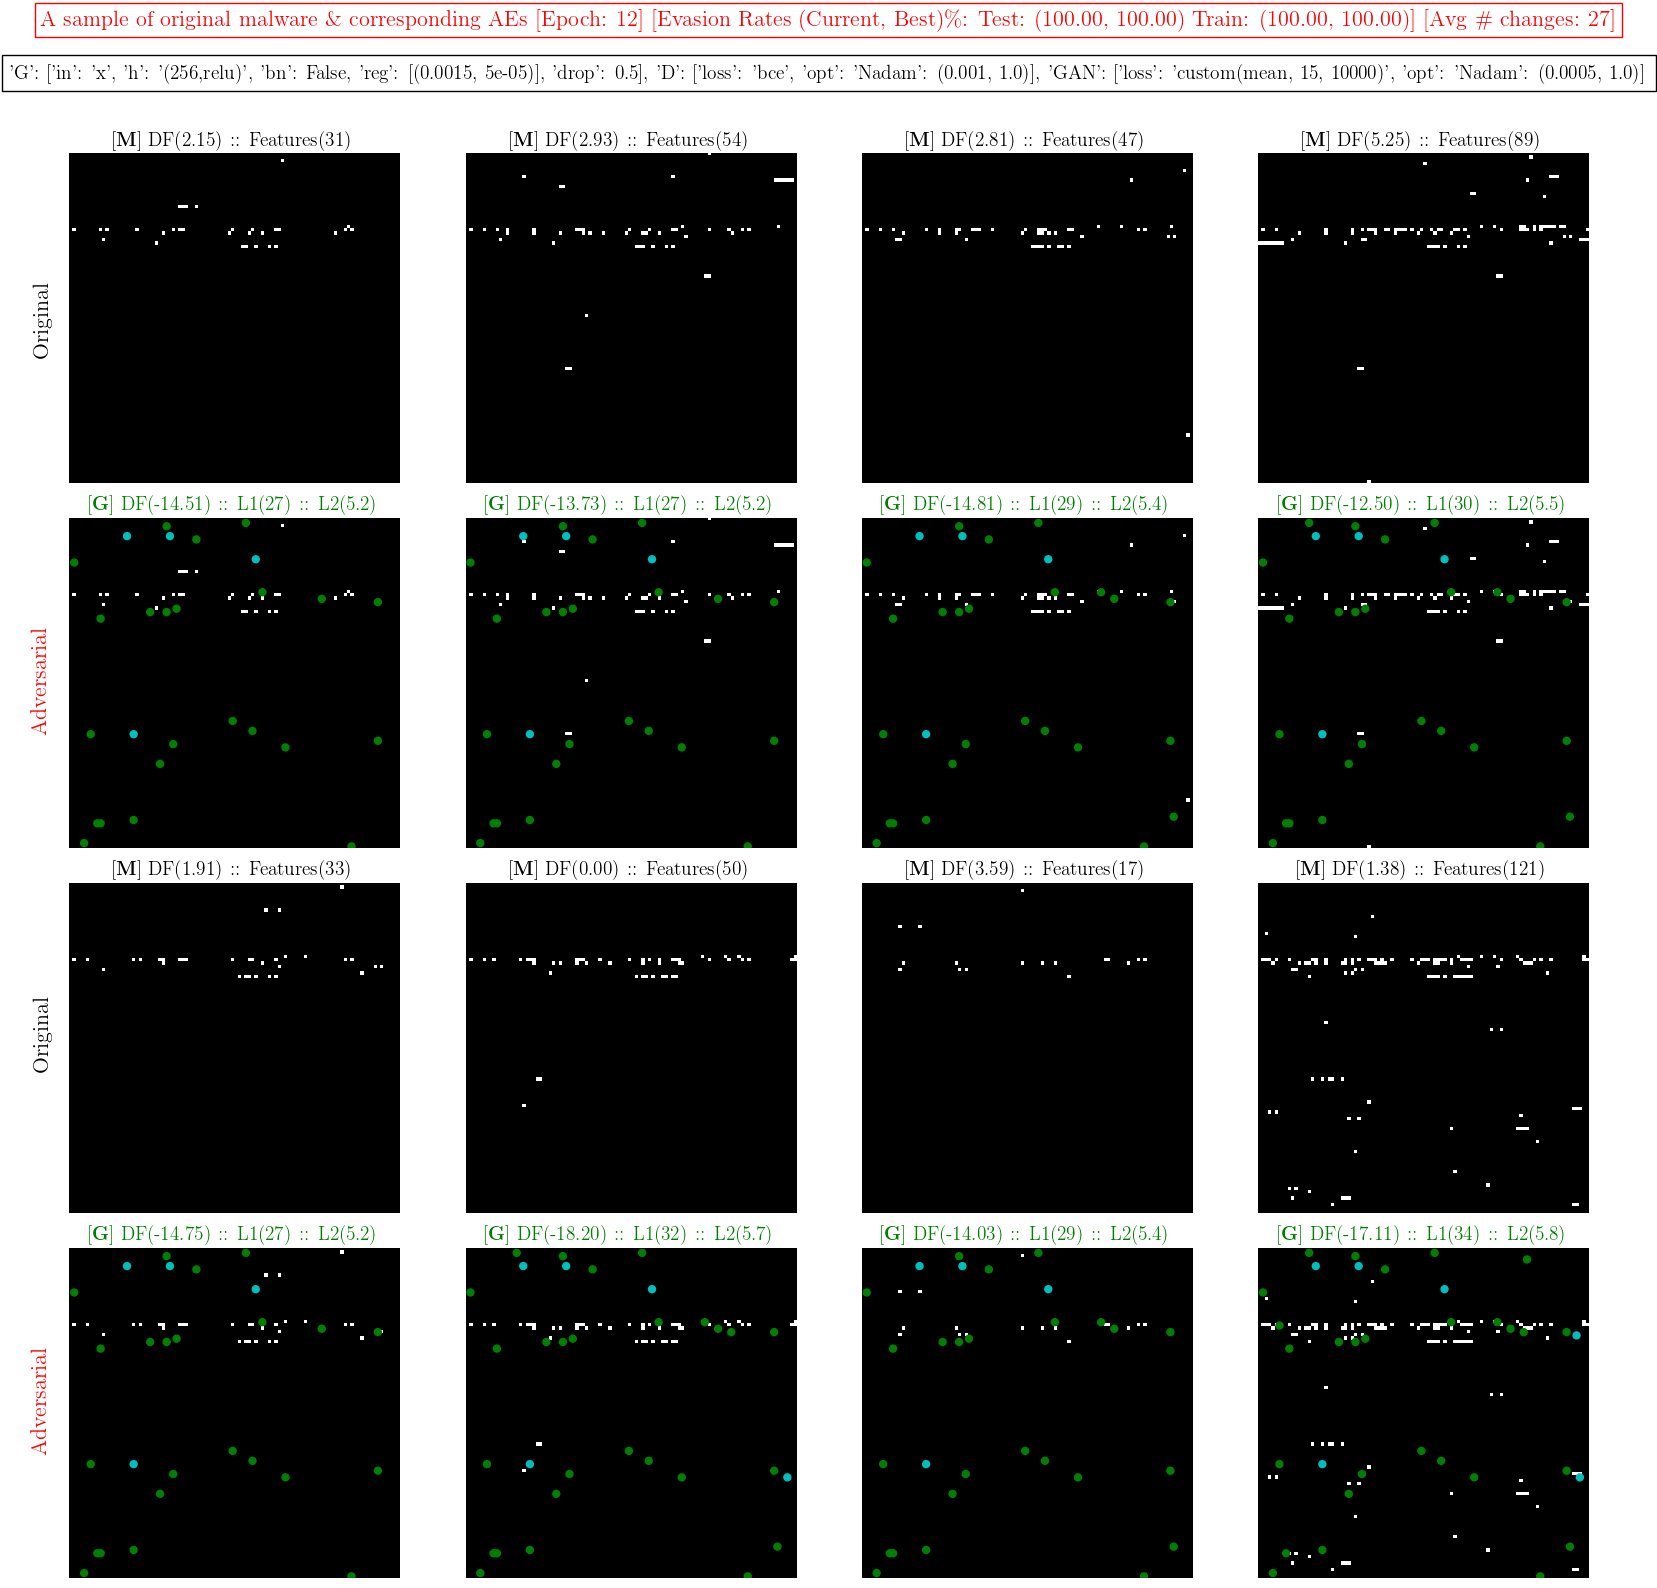


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [11] epochs, with avg 27.4 and max 127.0 changes per sample (on the test set) ... GAN Loss: [8.11995611]
######################################################################################################################################################


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [6.94887976]  <<<<
Epoch: 13
TPR Training : 0.00000000 | Avg # Changes: 25 ± SD(8.15) |  Change Quantiles (25%, 50%, 75%): [22, 23, 25] | Max 155
TPR Testing  : 0.00000000 | Avg # Changes: 25 ± SD(7.98) |  Change Quantiles (25%, 50%, 75%): [22, 23, 25] | Max: 123



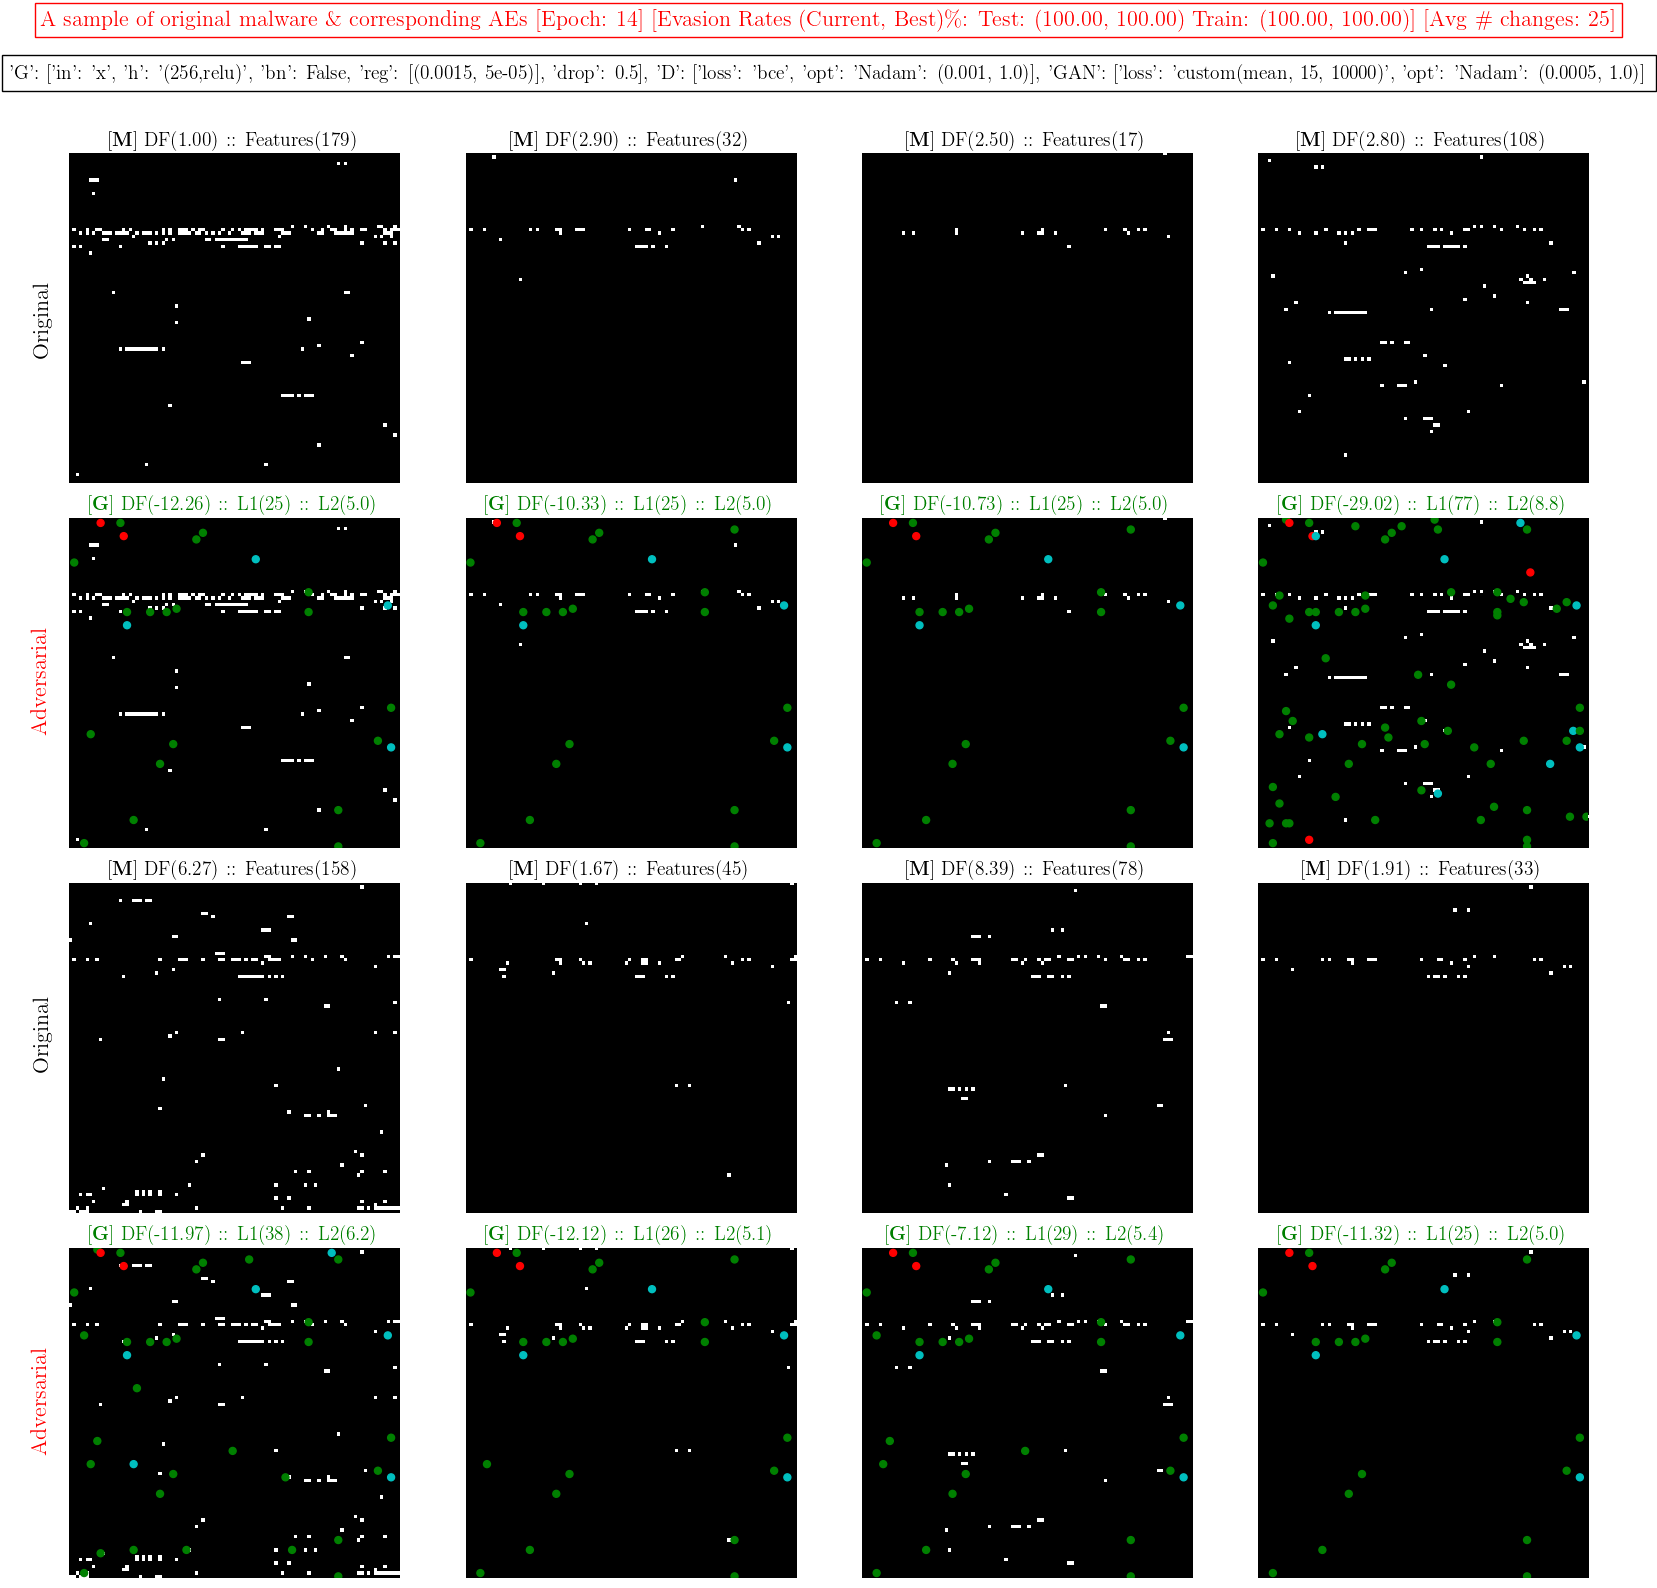


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [13] epochs, with avg 24.6 and max 123.0 changes per sample (on the test set) ... GAN Loss: [6.94887976]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [15] epochs, with avg 27.7 and max 125.0 changes per sample (on the test set) ... GAN Loss: [7.44351482]
######################################################################################################################################################



####################################################################################

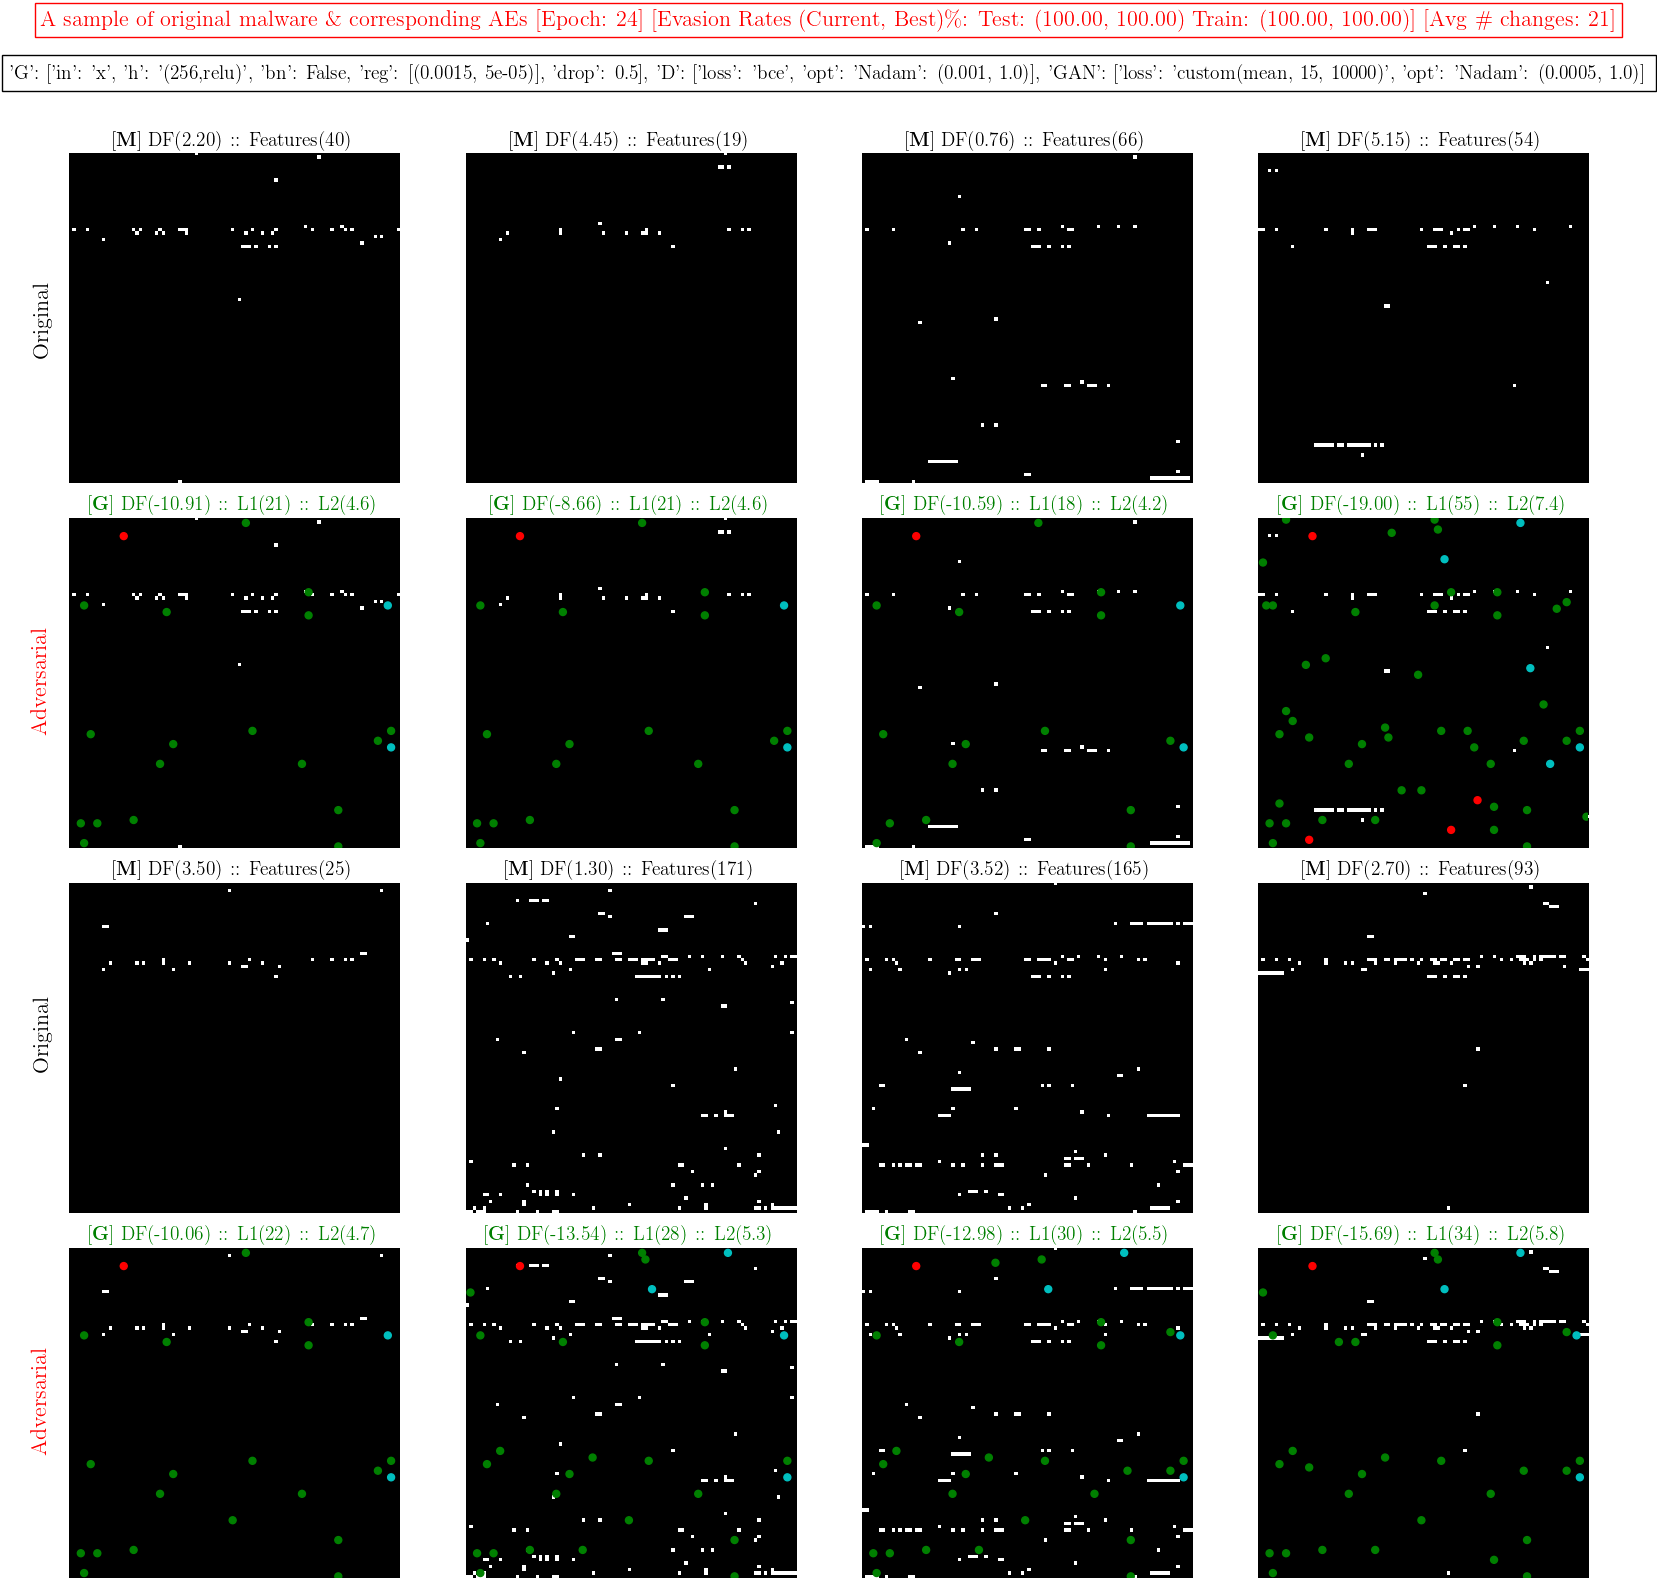


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [23] epochs, with avg 20.9 and max 130.0 changes per sample (on the test set) ... GAN Loss: [5.59705521]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [24] epochs, with avg 23.6 and max 124.0 changes per sample (on the test set) ... GAN Loss: [4.21783705]
######################################################################################################################################################



####################################################################################

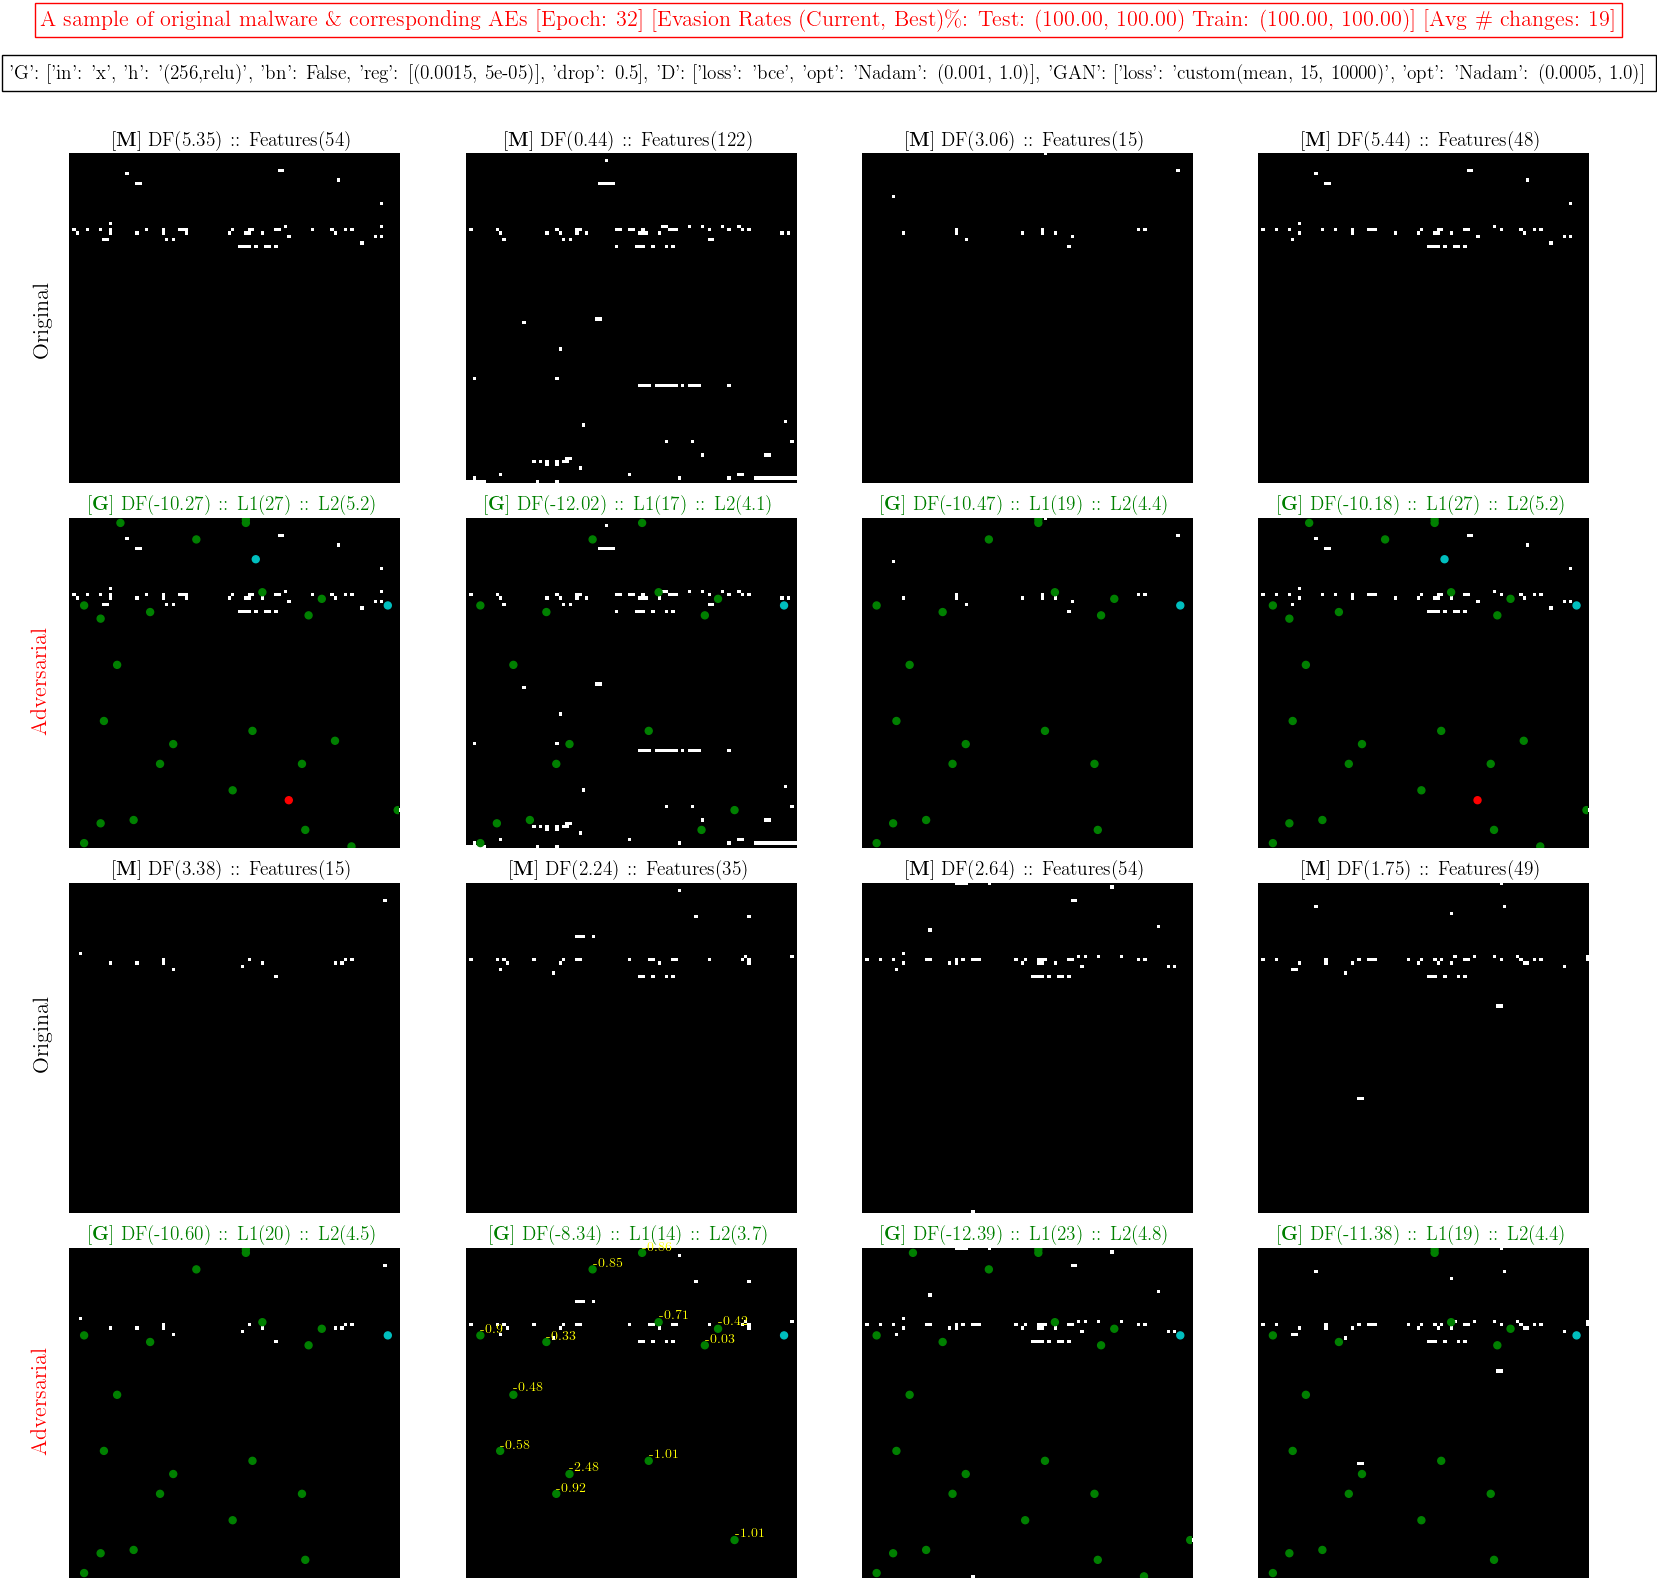


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [31] epochs, with avg 19.2 and max 130.0 changes per sample (on the test set) ... GAN Loss: [4.85739005]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [33] epochs, with avg 28.1 and max 134.0 changes per sample (on the test set) ... GAN Loss: [5.40155715]
######################################################################################################################################################



>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GA

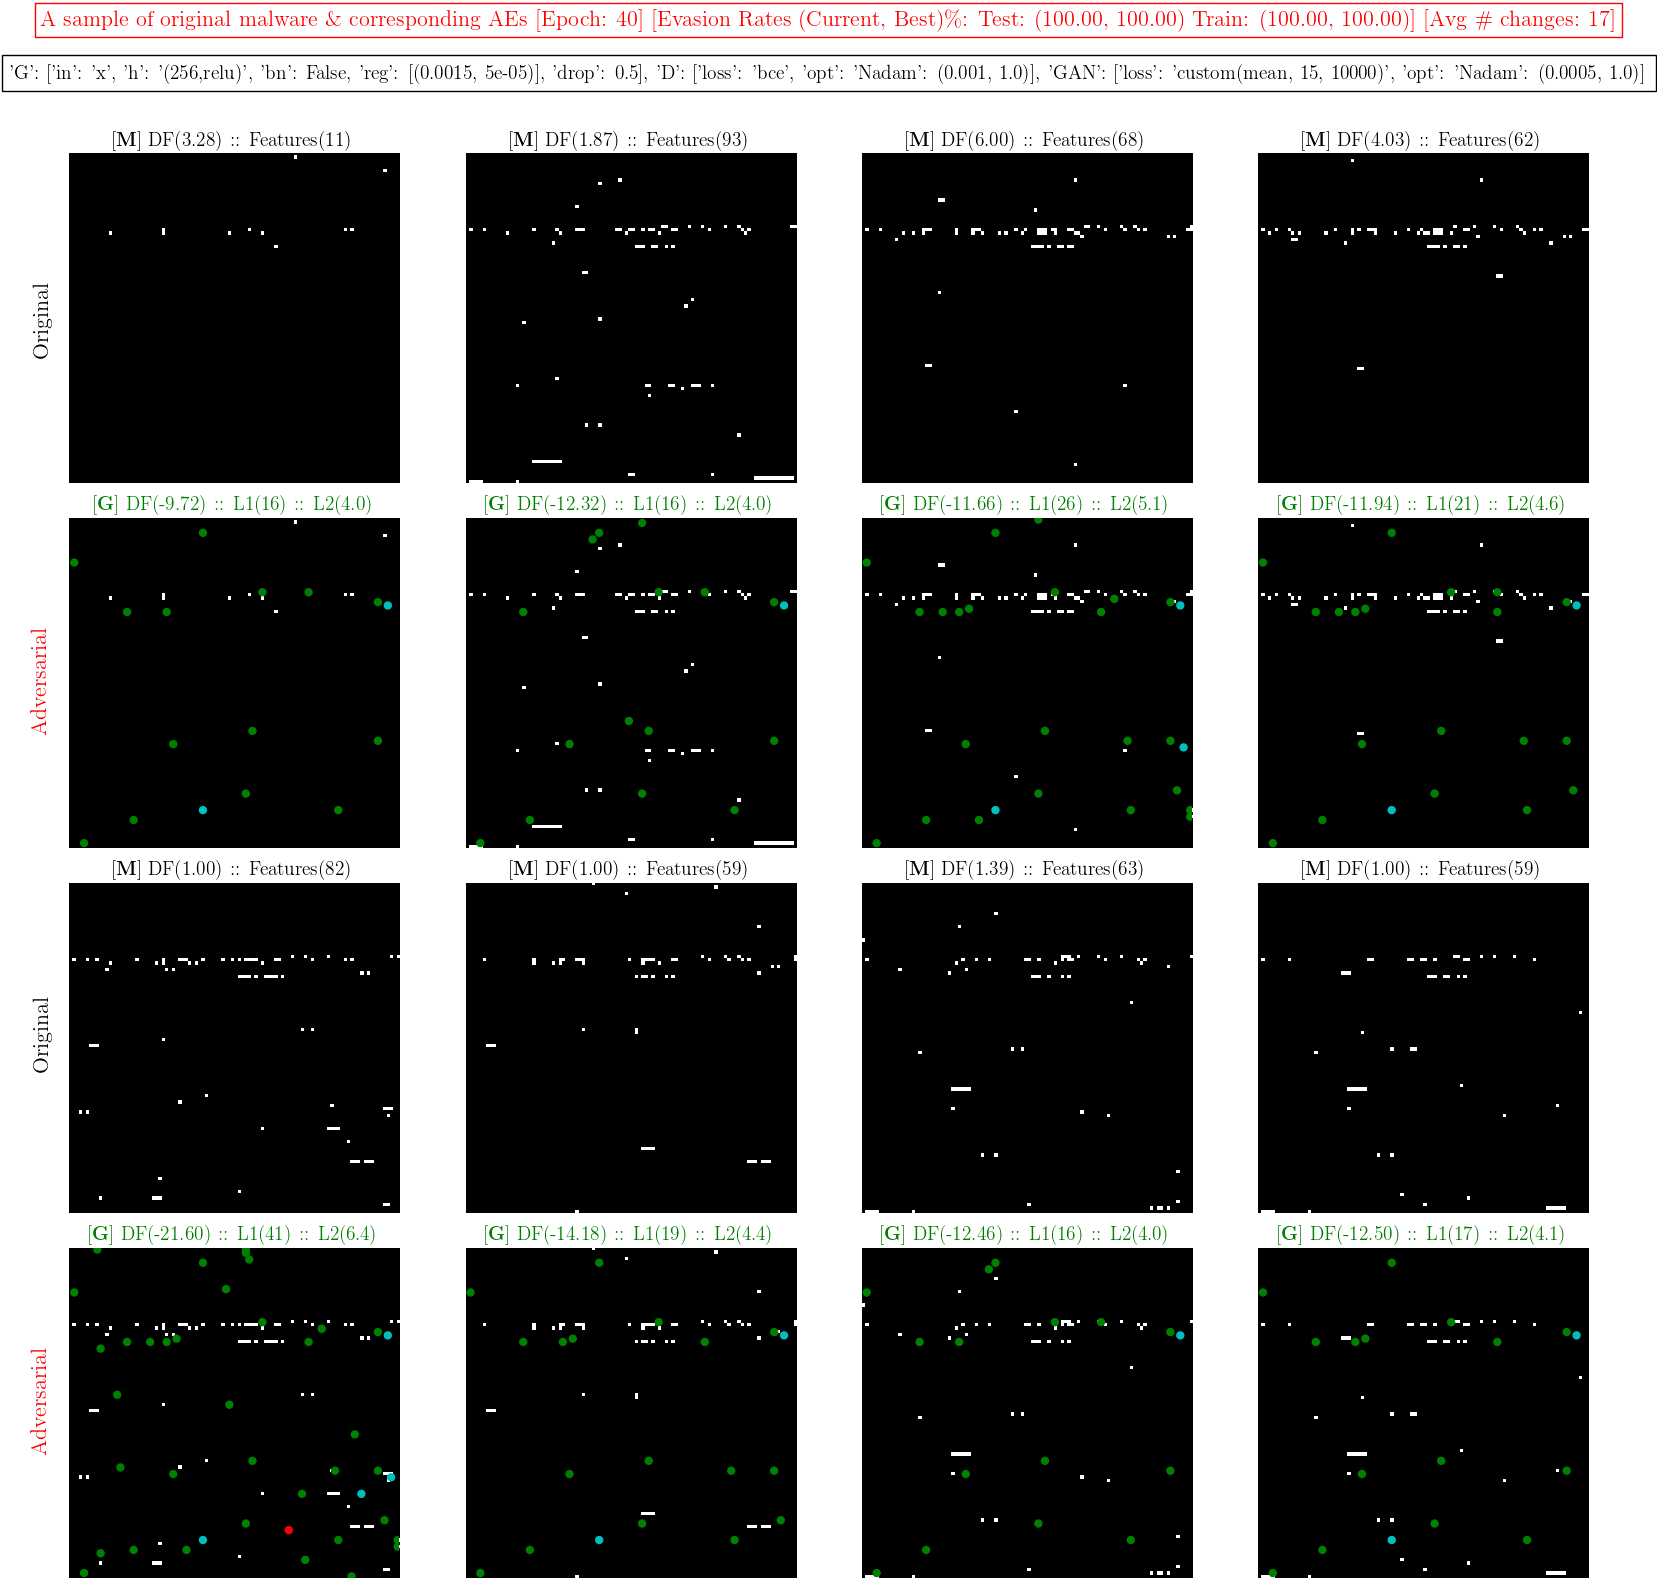


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [39] epochs, with avg 17.1 and max 110.0 changes per sample (on the test set) ... GAN Loss: [3.77616259]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [40] epochs, with avg 19.4 and max 107.0 changes per sample (on the test set) ... GAN Loss: [3.53307880]
######################################################################################################################################################



####################################################################################

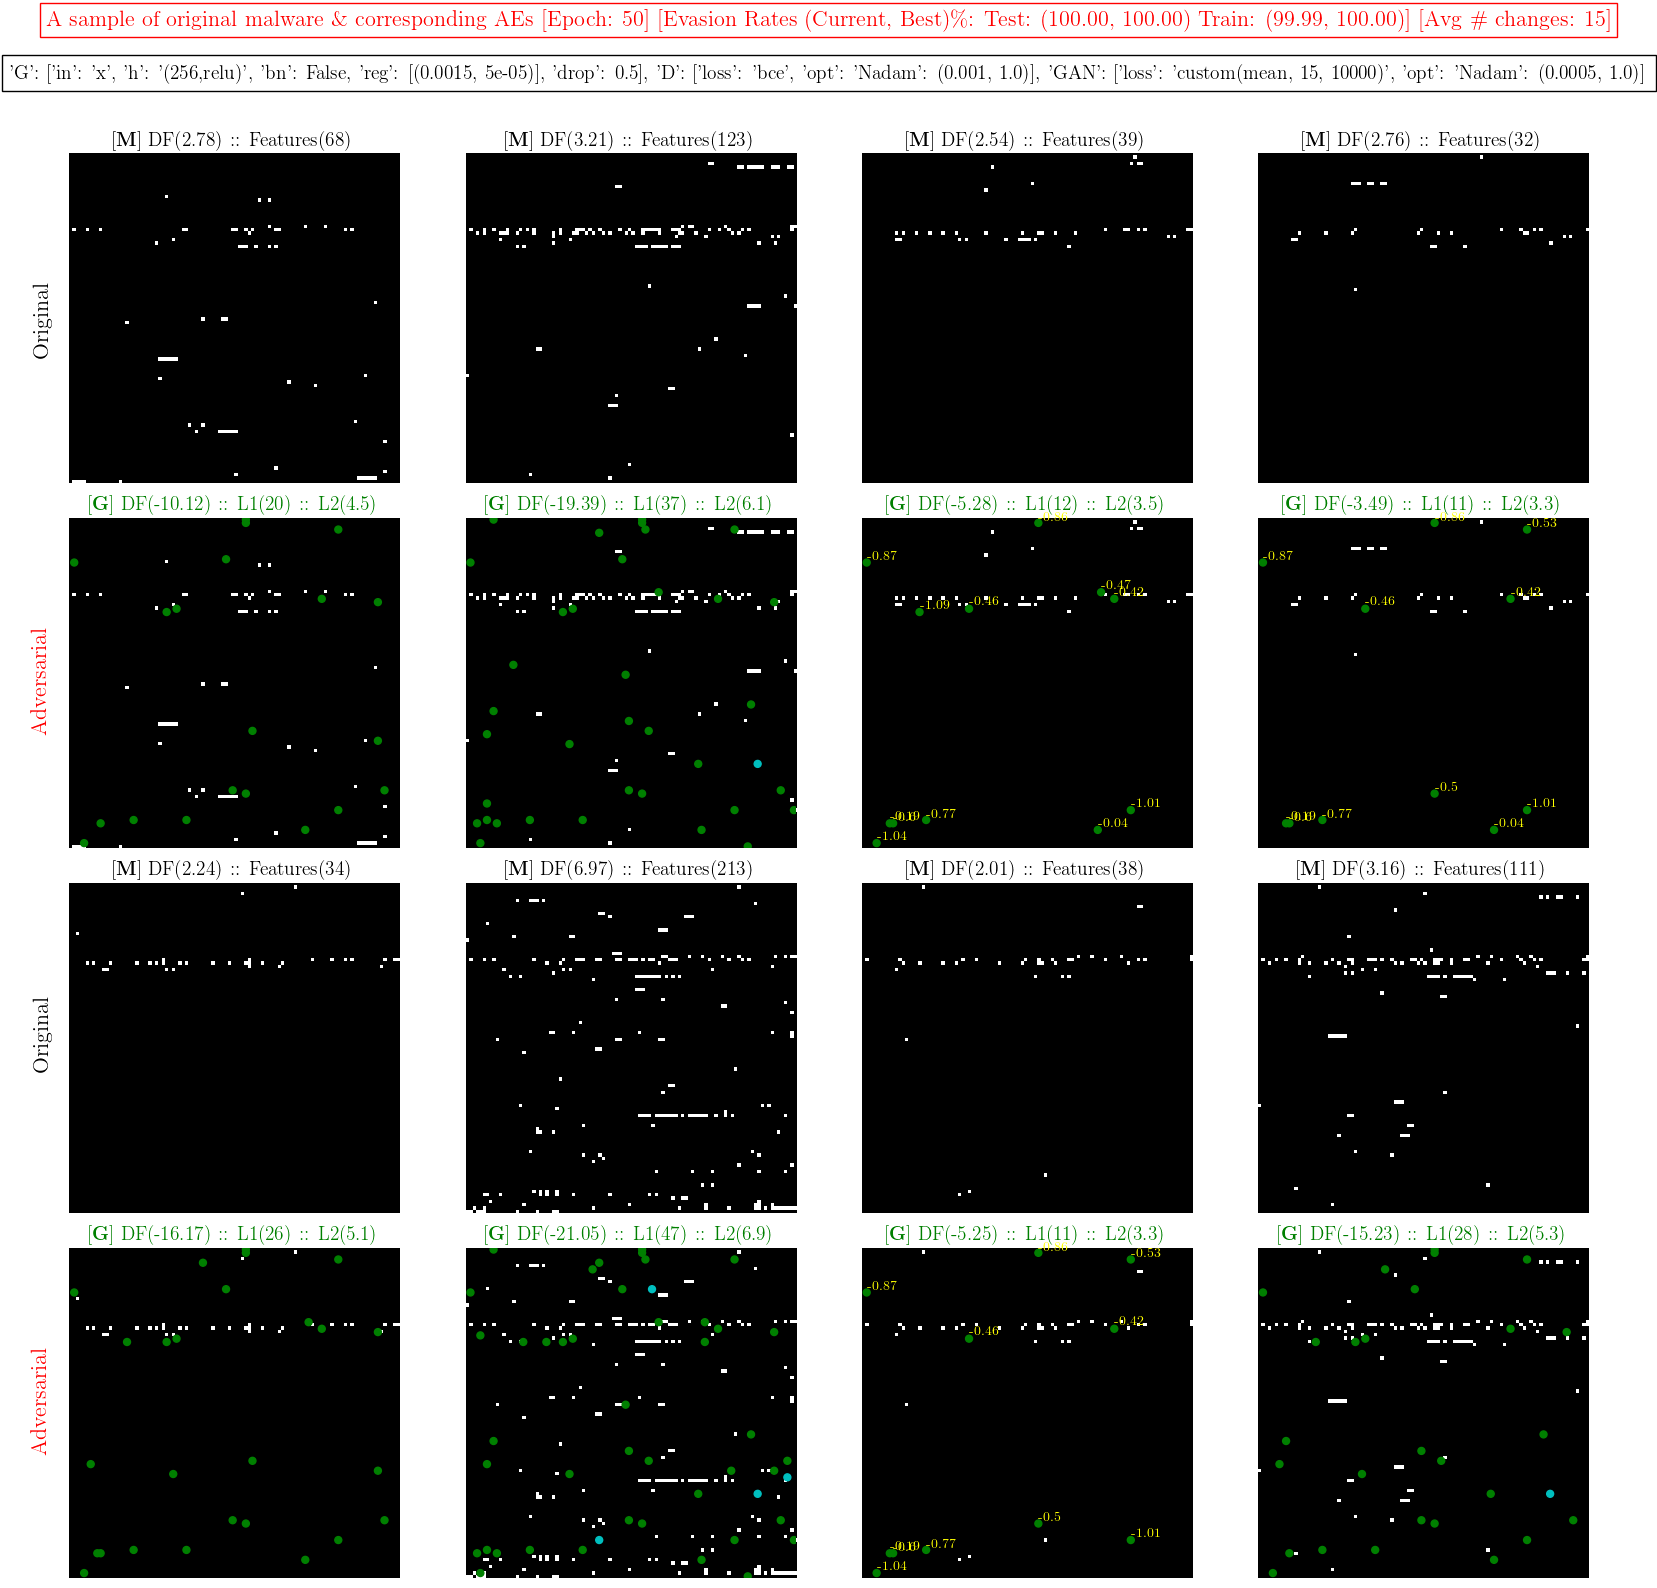


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [49] epochs, with avg 15.1 and max 108.0 changes per sample (on the test set) ... GAN Loss: [2.11792060]
######################################################################################################################################################


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [2.36765166]  <<<<
Epoch: 52
TPR Training : 0.00000000 | Avg # Changes: 12 ± SD(7.85) |  Change Quantiles (25%, 50%, 75%): [7, 9, 13] | Max 127
TPR Testing  : 0.00000000 | Avg # Changes: 11 ± SD(8.06) |  Change Quantiles (25%, 50%, 75%): [7, 9, 13] | Max: 130



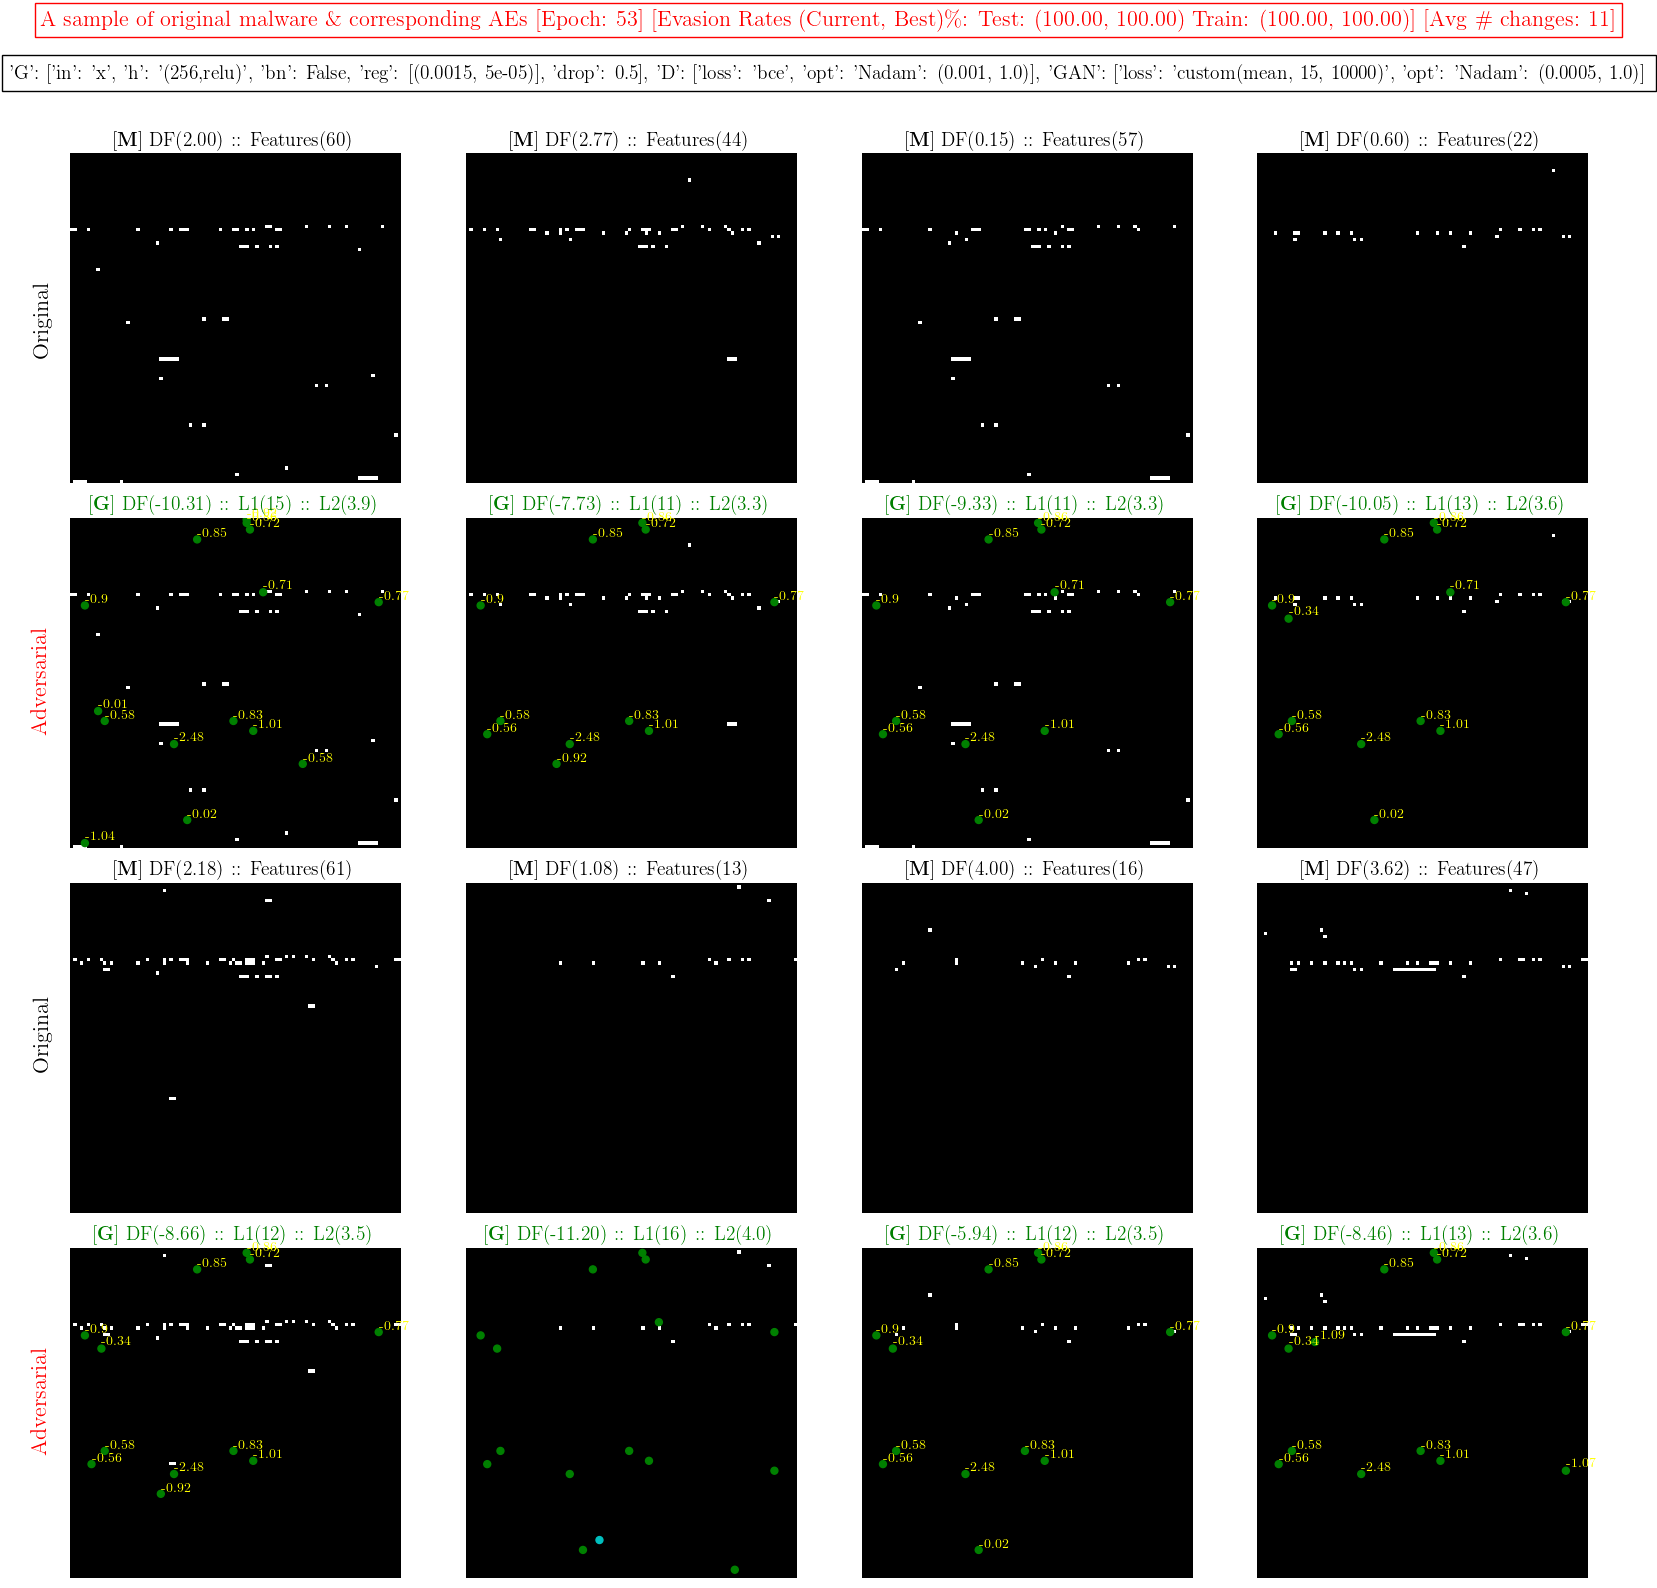


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [52] epochs, with avg 11.3 and max 130.0 changes per sample (on the test set) ... GAN Loss: [2.36765166]
######################################################################################################################################################

Training CONVERGED. Target Evasion Rate achieved within max changes...TRAINING ENDS HERE #

######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [54] epochs, with avg 15.0 and max 84.0 changes per sample (on the test set) ... GAN Loss: [2.36366097]
####################################################################################################################################################

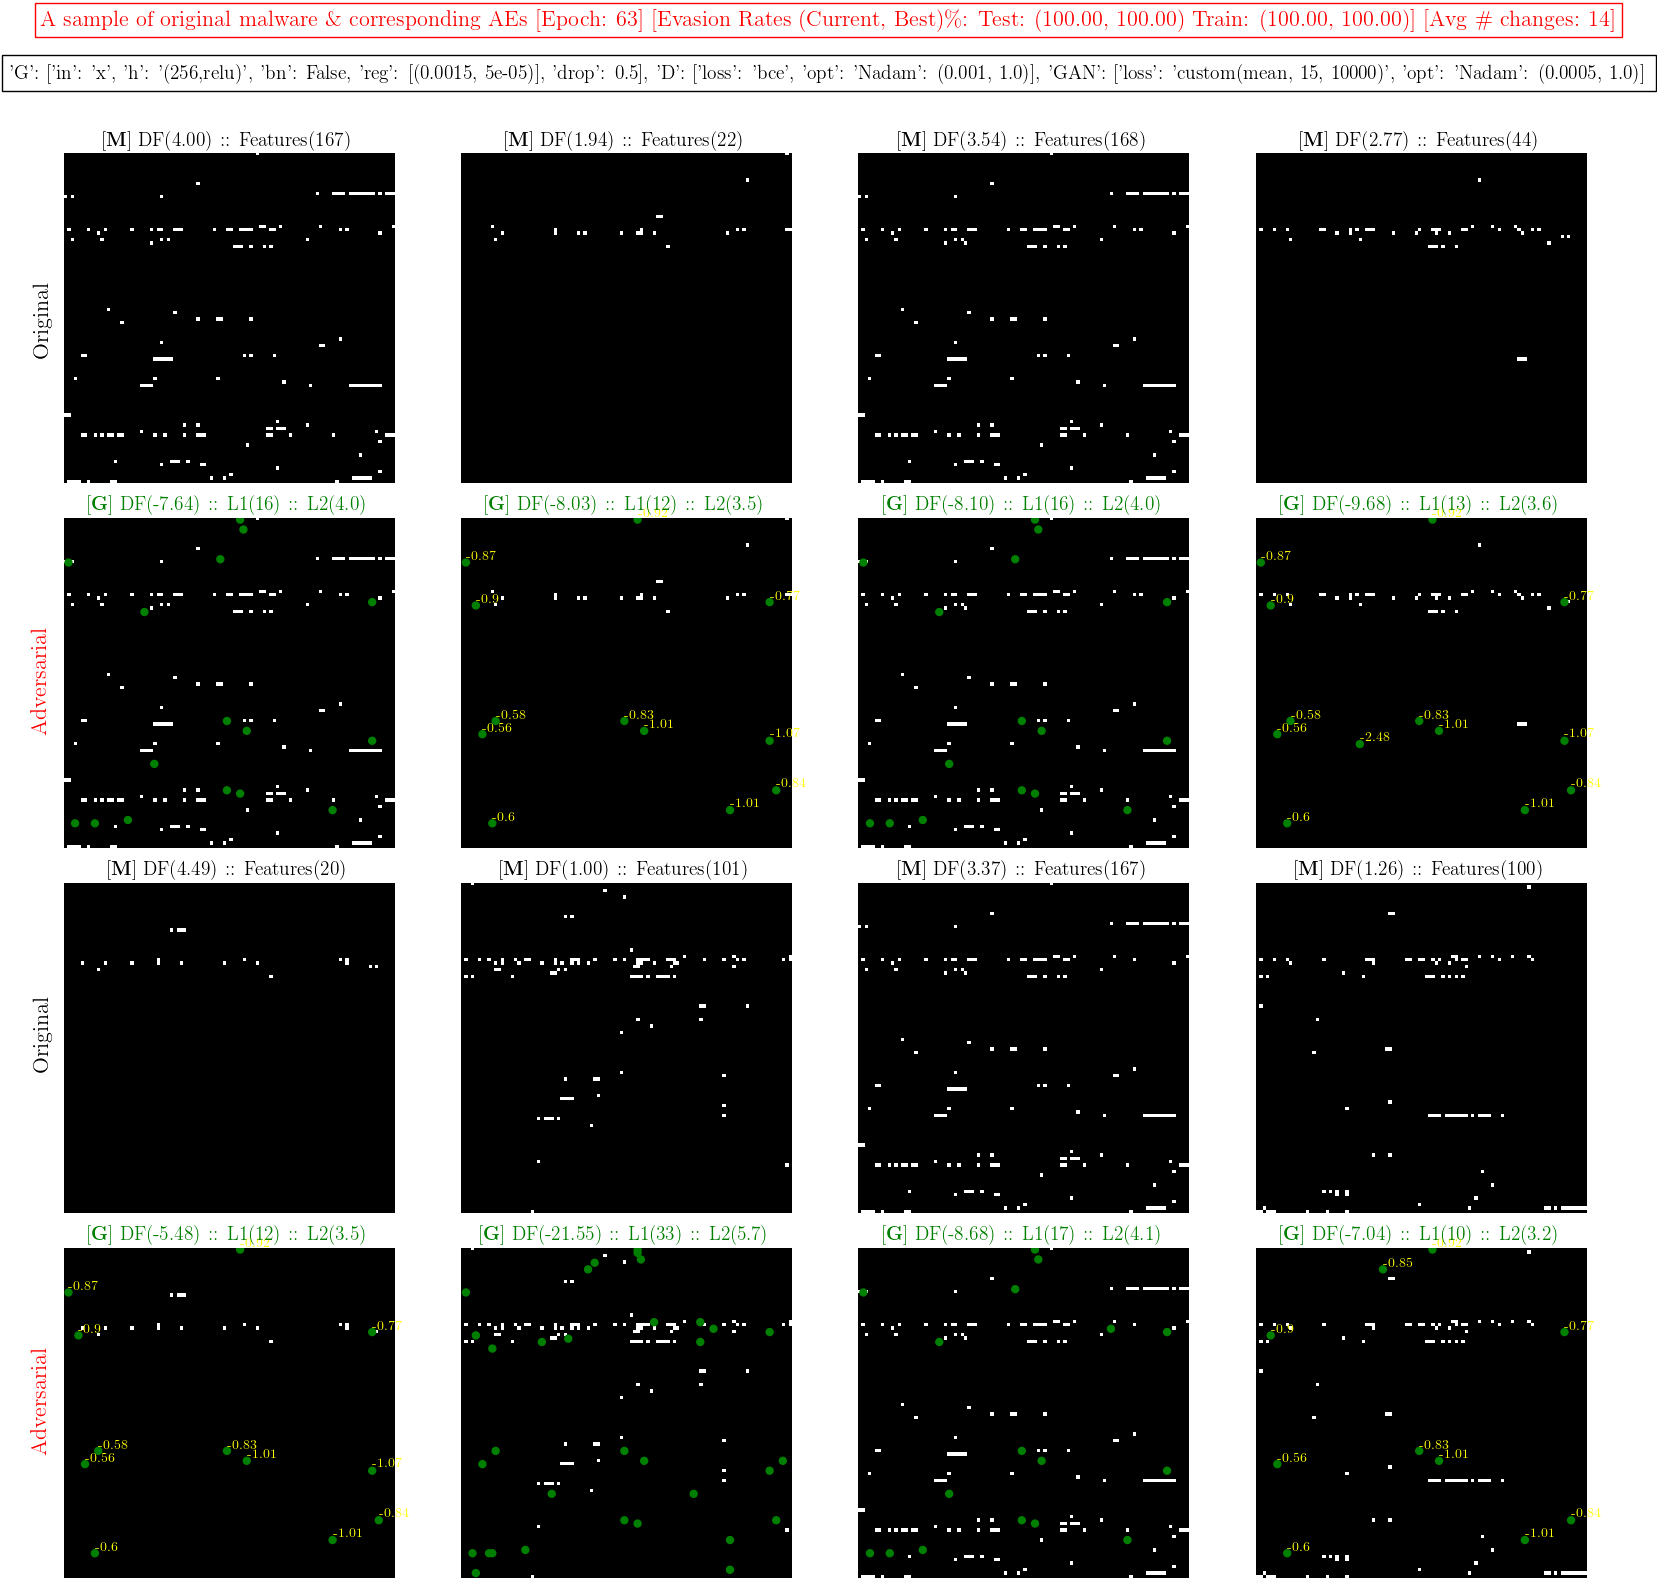


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [70] epochs, with avg 18.1 and max 125.0 changes per sample (on the test set) ... GAN Loss: [2.77743172]
######################################################################################################################################################



######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [71] epochs, with avg 14.4 and max 116.0 changes per sample (on the test set) ... GAN Loss: [2.55309857]
######################################################################################################################################################

Target Evasion Rate achieved within max changes...

*** Checking progress *** GAN Los

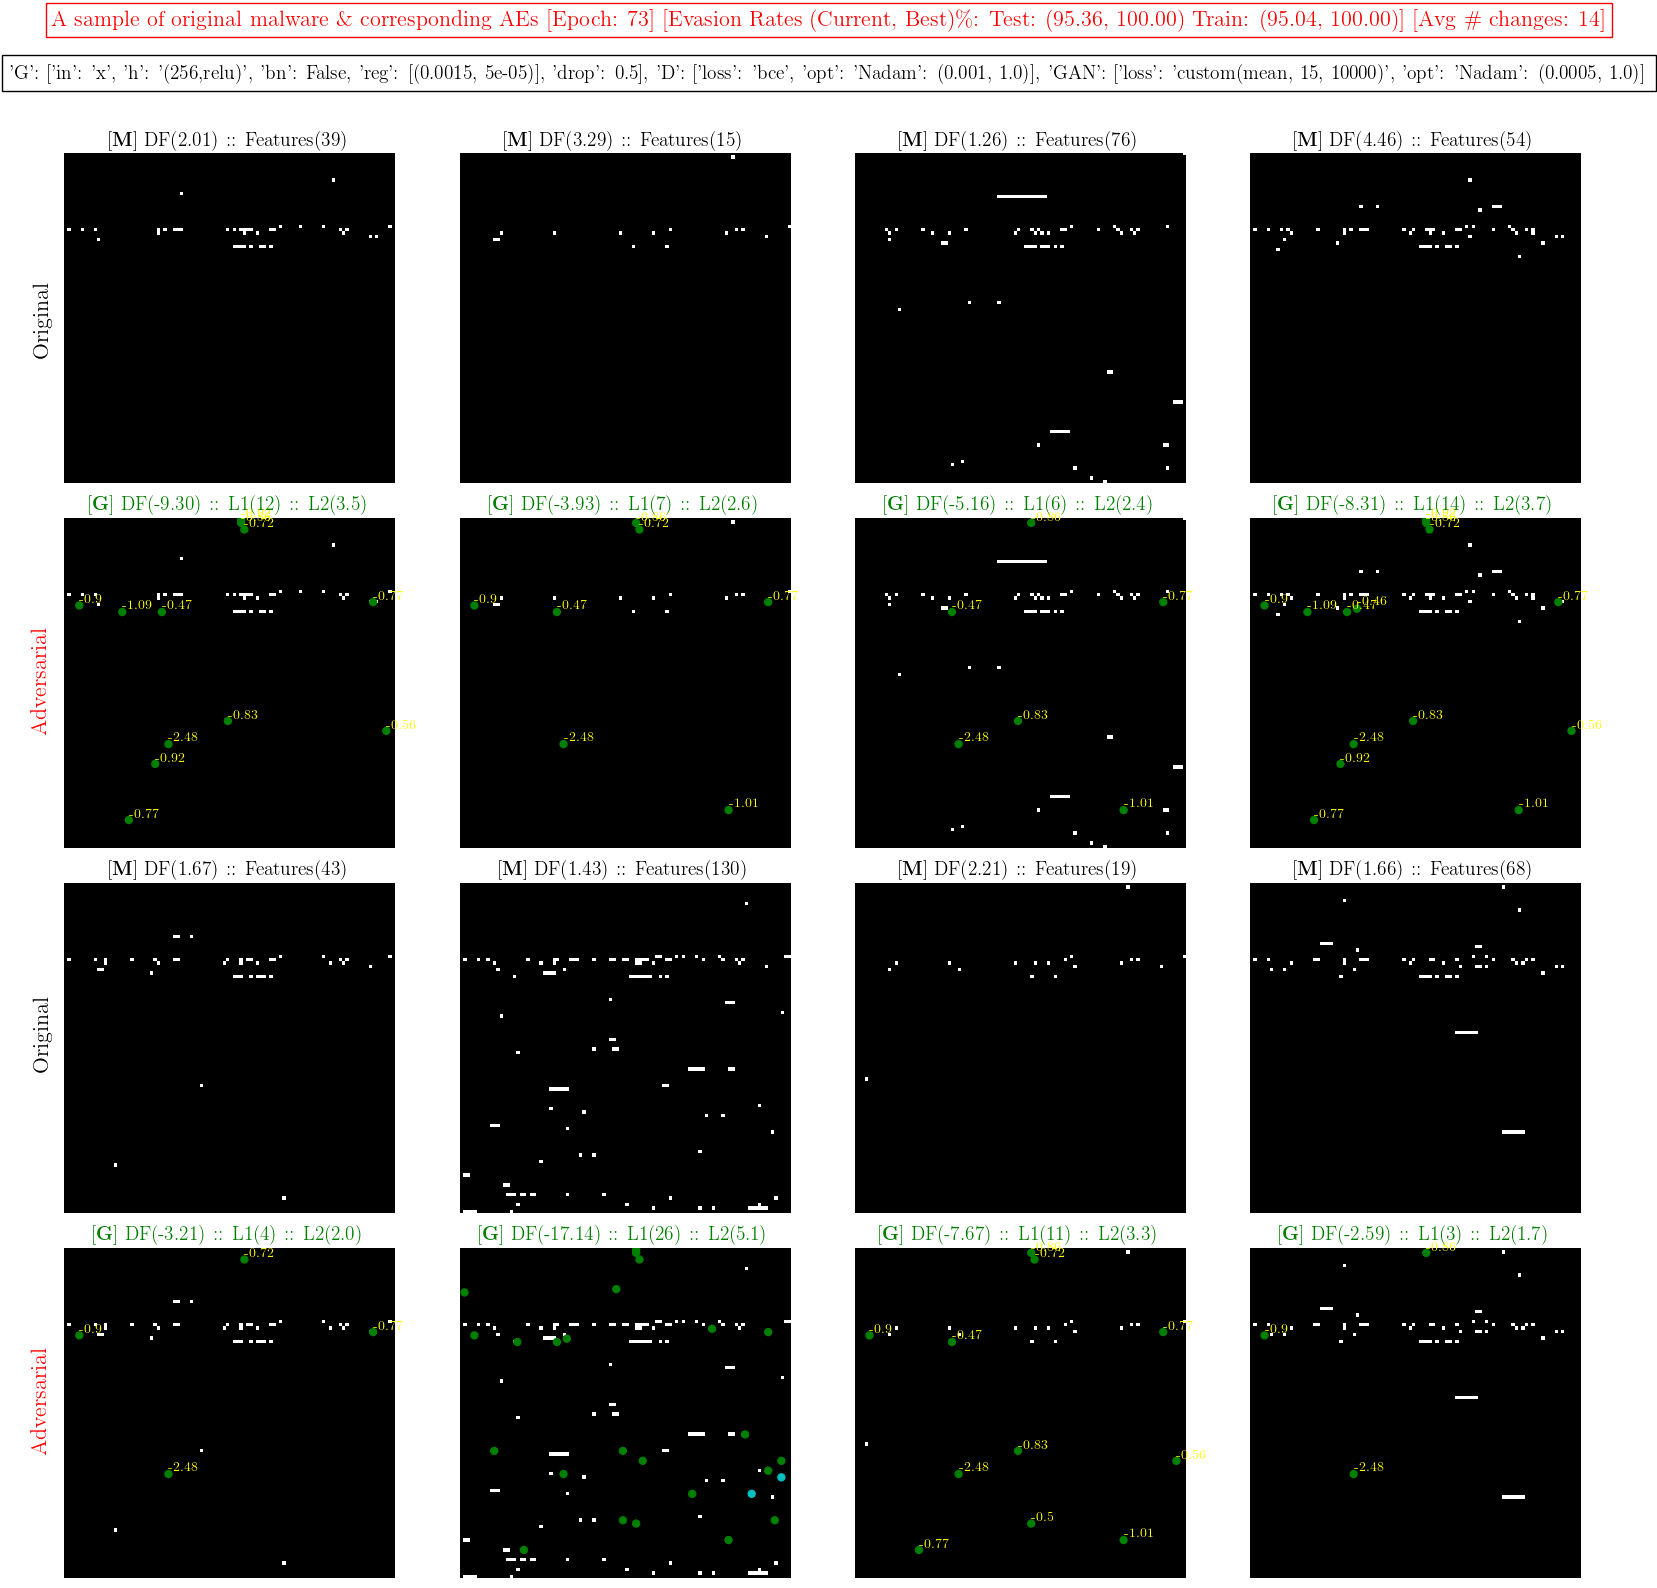


*** Checking progress *** GAN Loss: [2.54497018] ***
Epoch: 82
TPR Training : 0.00071556 | Avg # Changes: 21 ± SD(10.95) |  Change Quantiles (25%, 50%, 75%): [14, 21, 26] | Max 113
TPR Testing  : 0.00057954 | Avg # Changes: 21 ± SD(10.89) |  Change Quantiles (25%, 50%, 75%): [15, 21, 25] | Max: 112



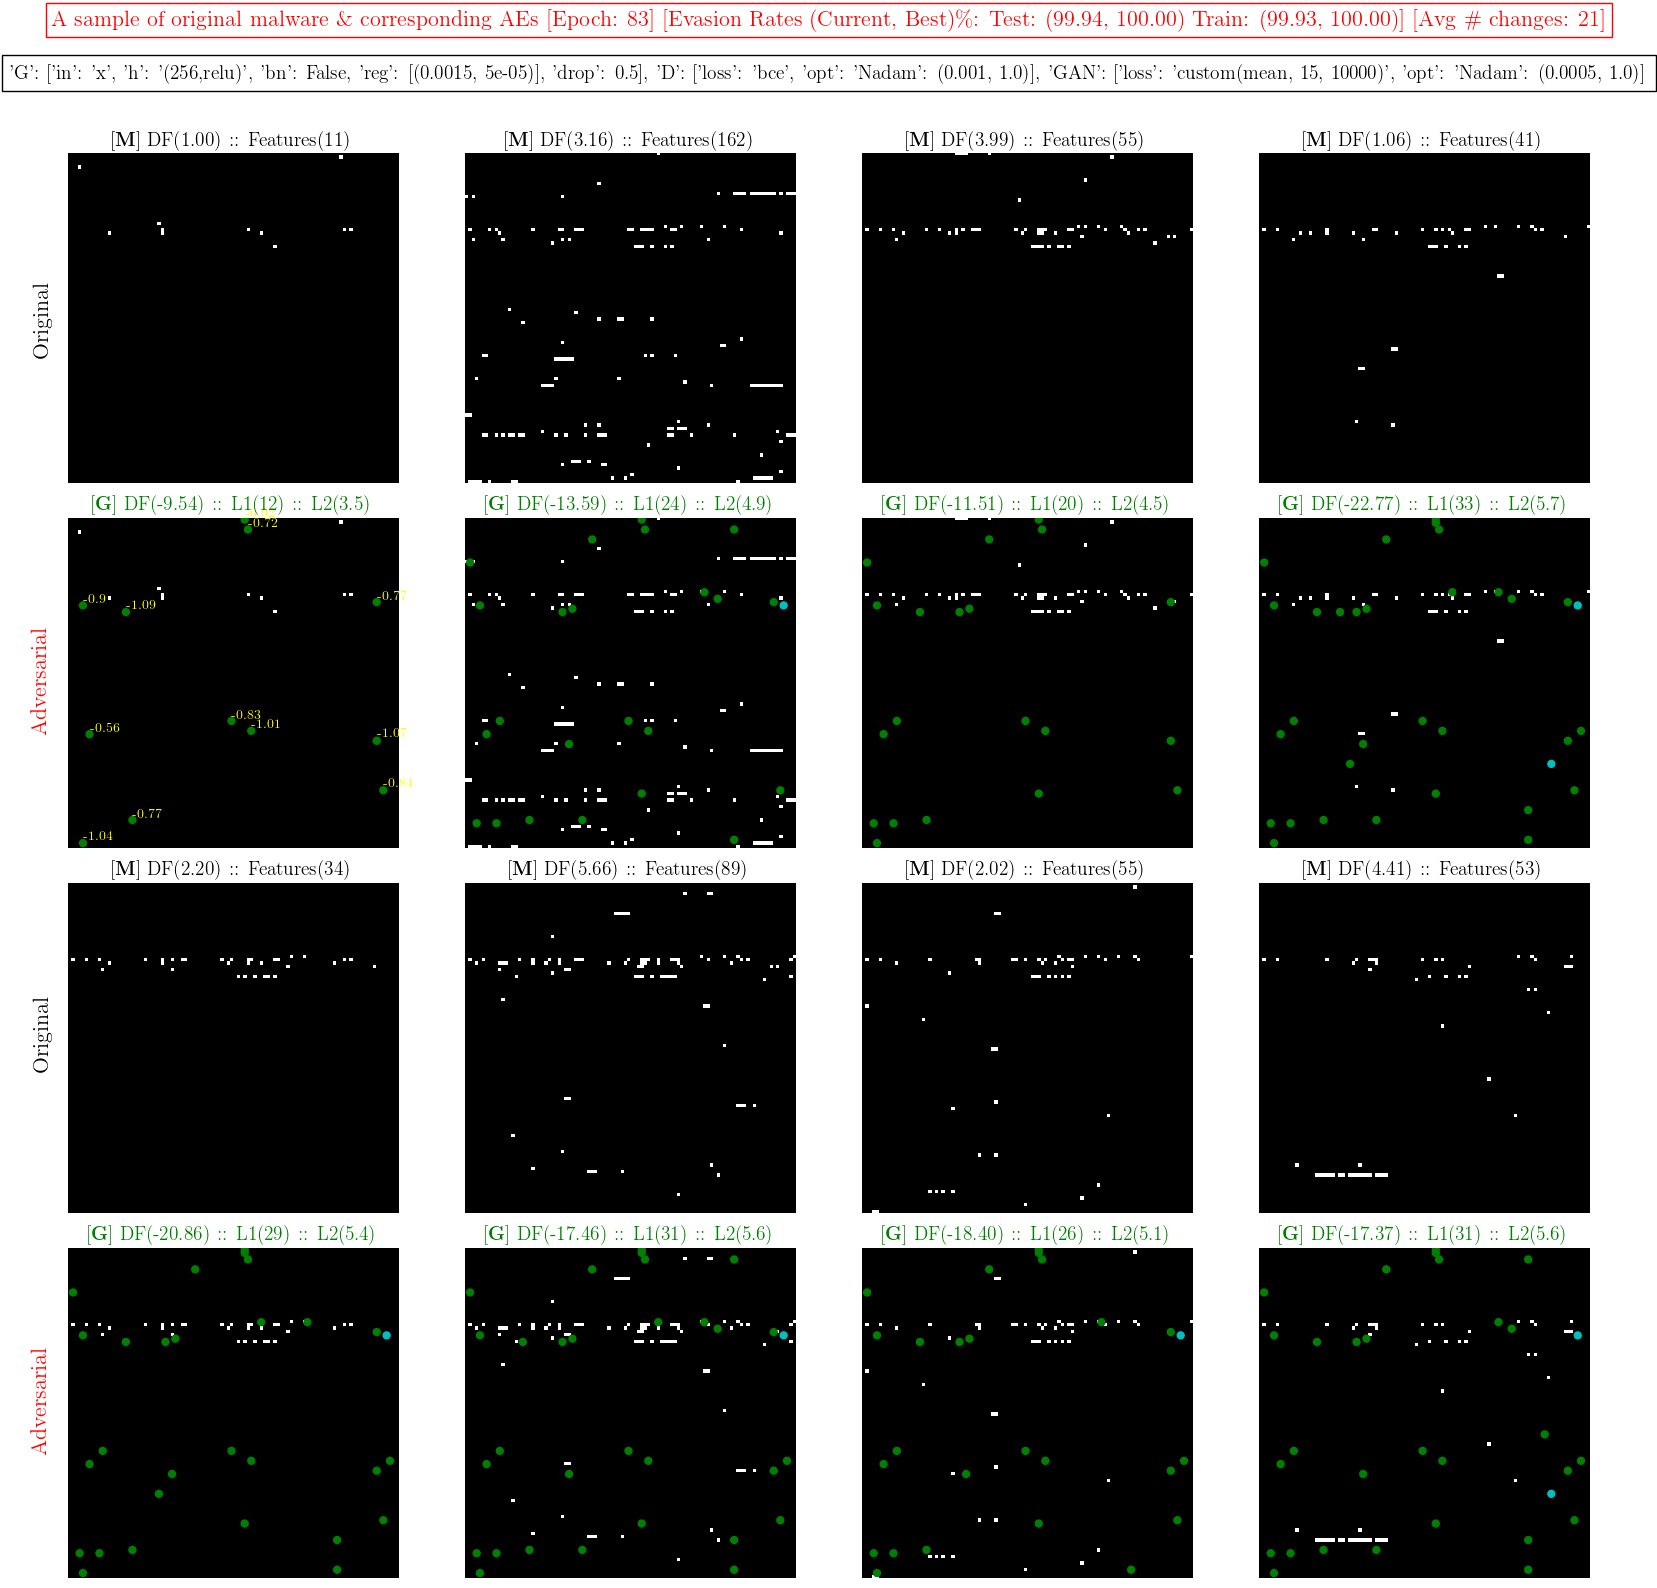


*** Checking progress *** GAN Loss: [2.65156243] ***
Epoch: 92
TPR Training : 0.00000000 | Avg # Changes: 25 ± SD(9.63) |  Change Quantiles (25%, 50%, 75%): [19, 23, 28] | Max 109
TPR Testing  : 0.00028977 | Avg # Changes: 25 ± SD(9.43) |  Change Quantiles (25%, 50%, 75%): [20, 23, 28] | Max: 99



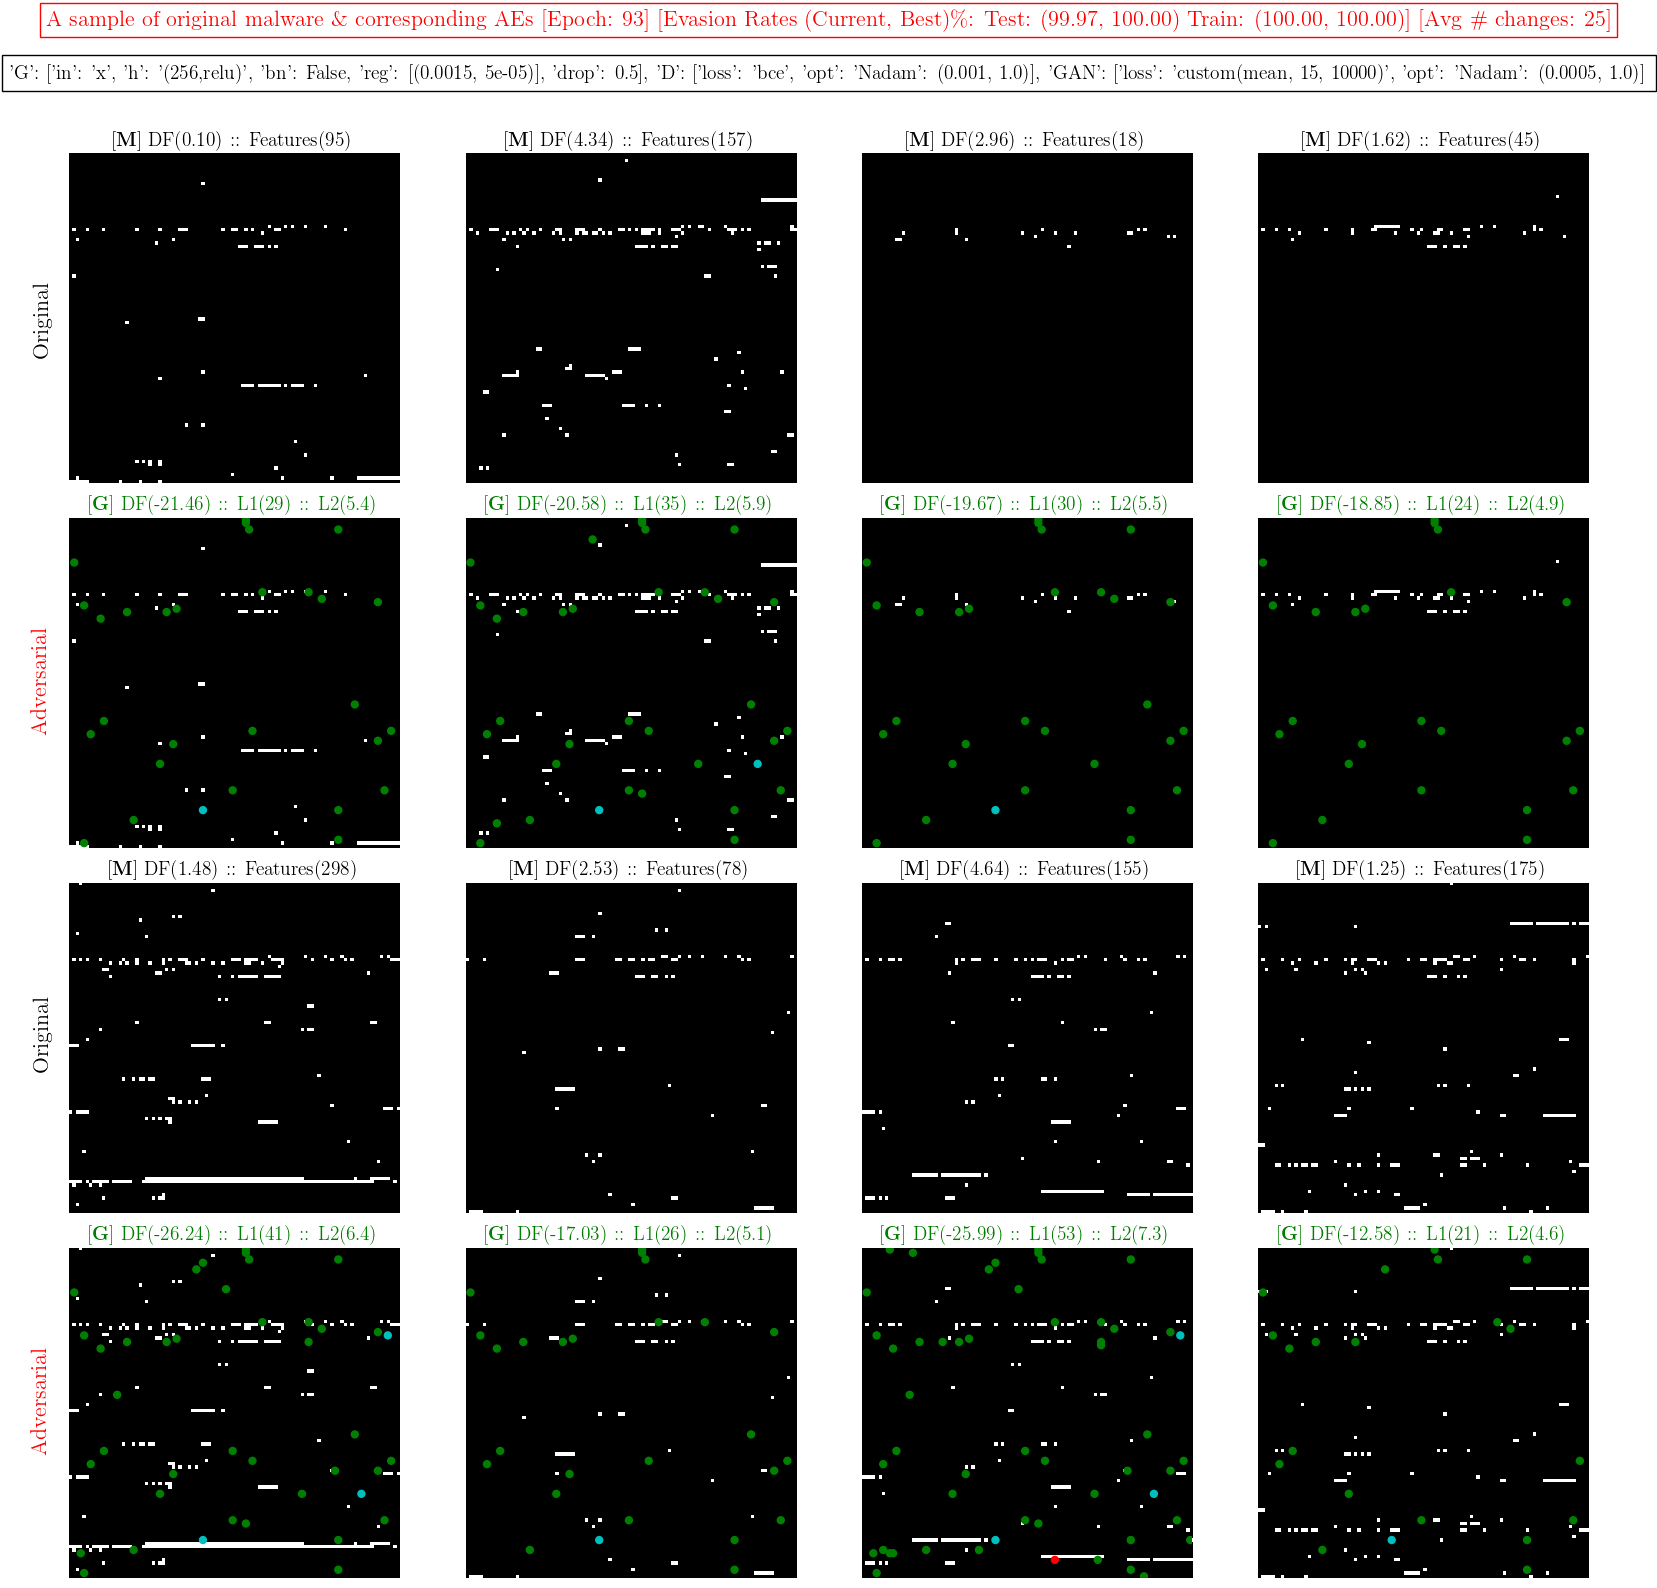


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [97] epochs, with avg 27.1 and max 108.0 changes per sample (on the test set) ... GAN Loss: [2.65773397]
######################################################################################################################################################




#####################################################################################################################################################################
# Finished 100 epochs in 42.52 minutes
# Best Evastion Rate = 100.0000% (lowest TPR = 0.0000%) achieved after 53 epochs, with avg 11.3 ± SD(8.1) |  Q1-3  [7, 9, 13] |  and max 130.0 changes per sample.
#####################################################################################################################################################################




In [ ]:
%autoreload

epochs=100
batch_size = 32
# batch_size = TP_train.shape[0]        # whole dataset

TPR_train, TPR_test, avg_diff_train, avg_diff_test, d_metrics, gan_metrics, best_G_path = \
    evadeGAN.train(target_model=model, epochs=epochs, batch_size=batch_size, 
                   n_progress=10, d_times=1, d_train_mal=True, d_train_adv=True,
                   gan_times=1, good_label=GOOD_LABEL, mal_label=MAL_LABEL,
                   X_mal_train=X_mal_train, X_mal_test=X_mal_test, 
                   good_batch_factor=1, X_good_train=X_good_train, 
                   X_good_test=X_good_test, max_changes=max_changes,
                   minTPR_threshold=1-targetEvasionRate, 
                   gan_dir=GAN_DIR, smooth_alpha=1.0)

In [ ]:
%autoreload

### **Plot the TPR and training metrics**

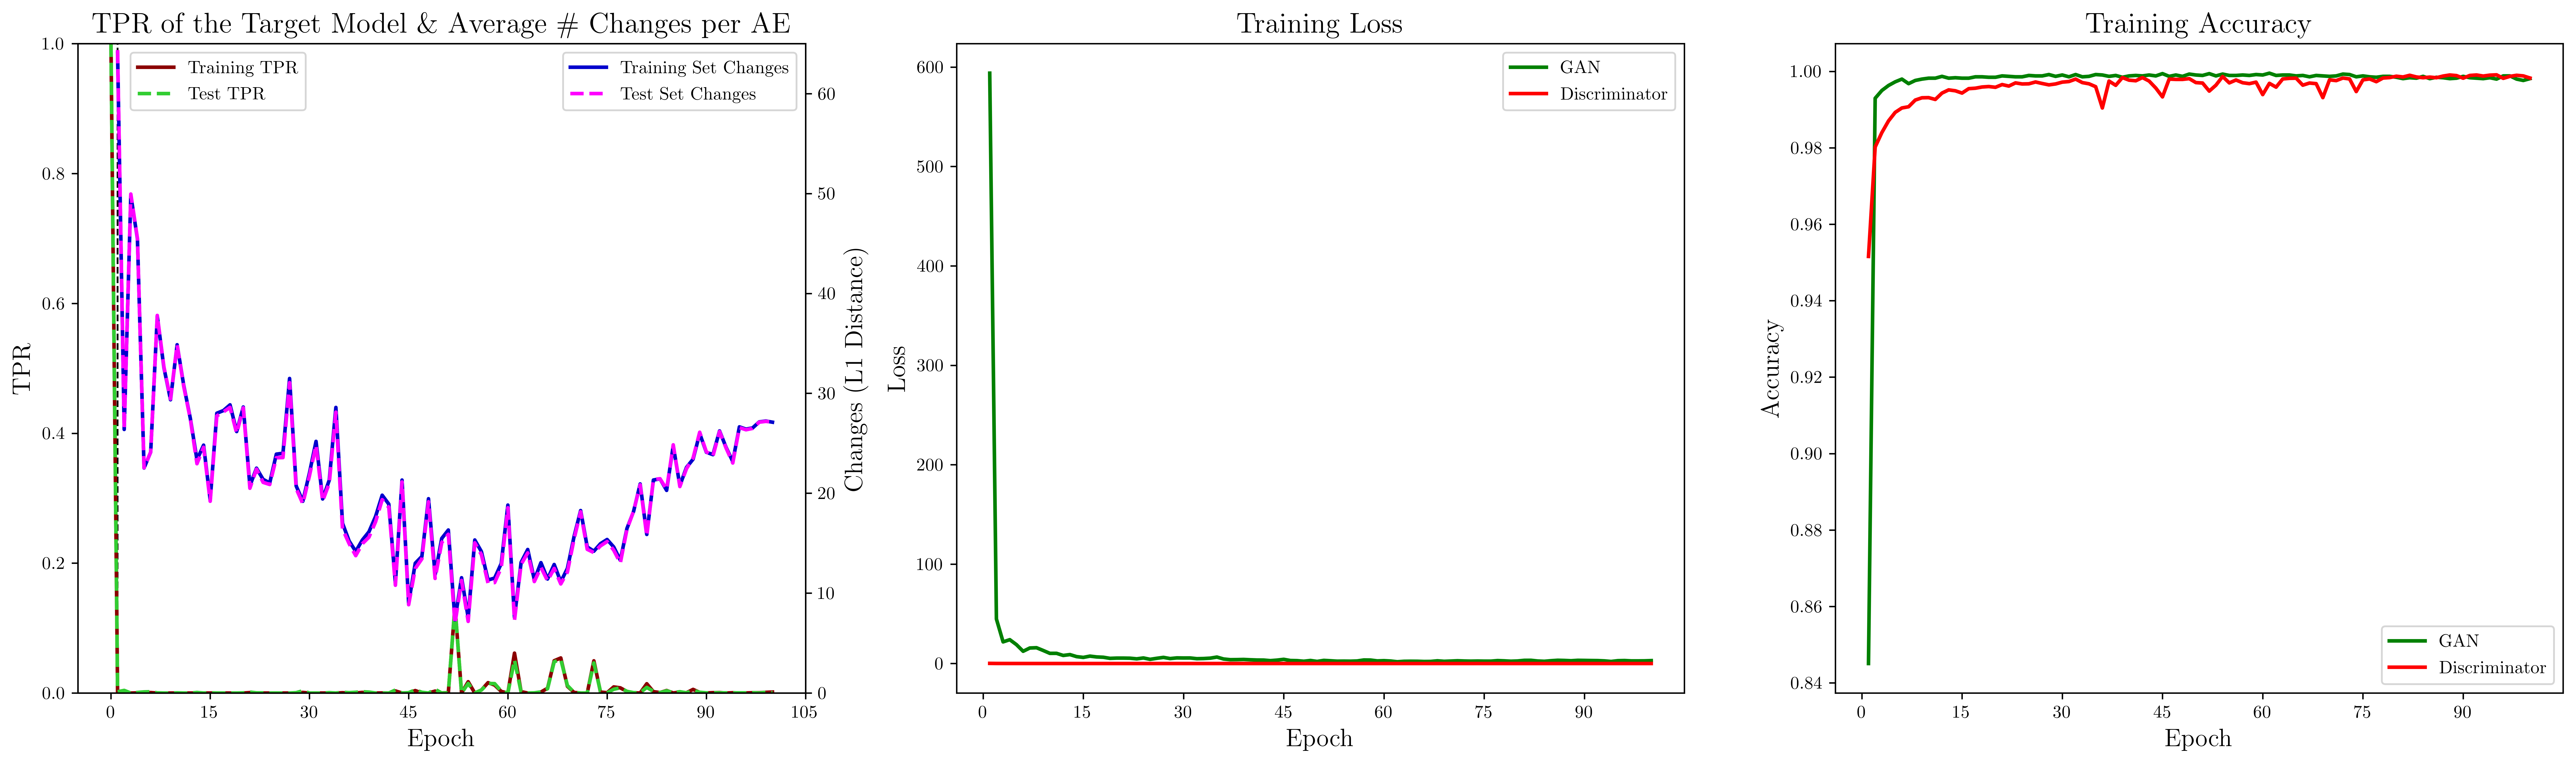

In [ ]:
%autoreload
plot_TPR_metrics(TPR_train, TPR_test, avg_diff_train, avg_diff_test, 
                 d_metrics, gan_metrics)

### **How well does the discriminator approximate the target model?**

The discriminator is evaluated on all the samples that are **correctly classified** by the **target model (True Positives & True Negatives)**.

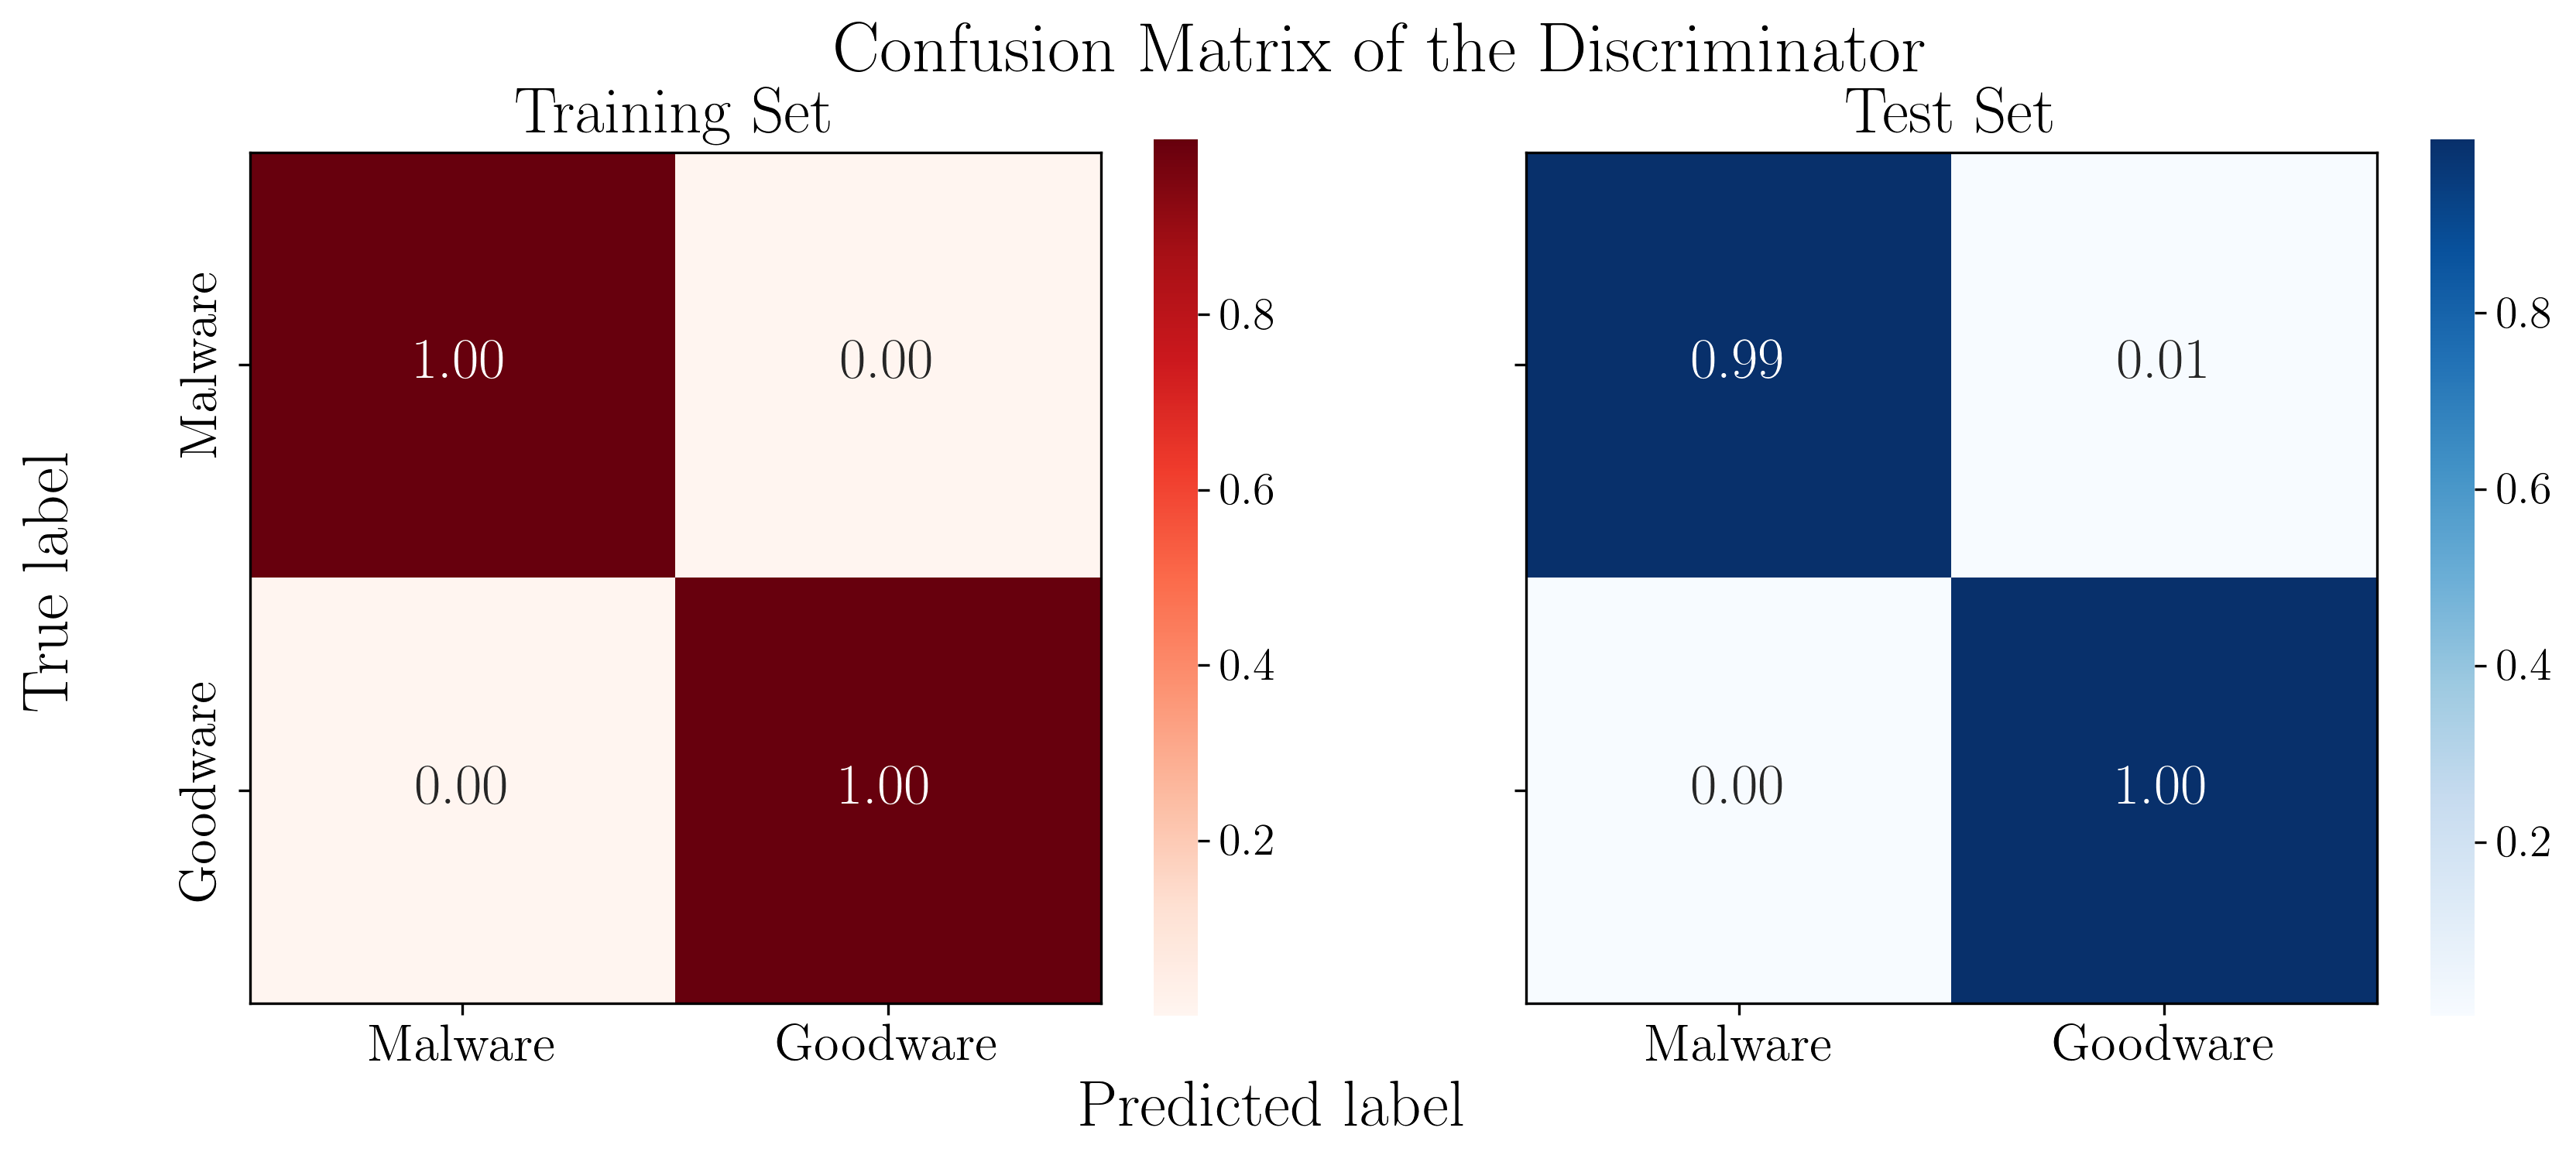

In [ ]:
%autoreload
# Evaluate discriminatior (how well does it approximate the target model)

Y_true_train = np.concatenate((MAL_LABEL * ones(X_mal_train.shape[0]),
                              GOOD_LABEL * ones(X_good_train.shape[0]))) 
Y_pred_train = \
    np.concatenate(
        (binarise(evadeGAN.discriminator.predict(X_mal_train), bin_threshold), 
        binarise(evadeGAN.discriminator.predict(X_good_train), bin_threshold))
    )

Y_true_test = np.concatenate((MAL_LABEL * ones(X_mal_test.shape[0]),
                              GOOD_LABEL * ones(X_good_test.shape[0]))) 
Y_pred_test = \
    np.concatenate(
        (binarise(evadeGAN.discriminator.predict(X_mal_test), bin_threshold),
         binarise(evadeGAN.discriminator.predict(X_good_test), bin_threshold))
    )

plot_confusion_matrix(Y_true_train, Y_pred_train, Y_true_test, Y_pred_test,
                      title="Confusion Matrix of the Discriminator")

## **Best Generator** ##

In [ ]:
generator = load_model(best_G_path)

In [ ]:
%autoreload
pd.options.display.max_rows = 1000

### **Generate AEs** ###

**A. Many X's**

In [ ]:
# Matrix to array
x_good_train = np.asarray(X_good_train)     # To analyse perturbations
x_mal_train = np.asarray(X_mal_train)       # To analyse perturbations
x_mal_test = np.asarray(X_mal_test)         # To generate AEs

z = np.random.uniform(0.0, 1.0,             # Dummy input, NOT used in EvadeGANx
        size=[X_mal_test.shape[0], z_dim])

x_adv = generator.predict([X_mal_test, z])
x_adv = binarise(x_adv).numpy()             # Binary AE
perturbs = x_adv - x_mal_test               # Delta = x' - x

**B. One X**

In [ ]:
N = 100
x_one = np.repeat(X_mal_test[0], N, axis=0)

z_one = np.random.uniform(0.0, 1.0,         # Dummy input, NOT used in EvadeGANx
            size=[N, z_dim])

x_adv_one = generator.predict([x_one, z_one])
x_adv_one = binarise(x_adv_one).numpy()     # Binary AE
perturbs_one = x_adv_one - x_one            # Delta = x' - x

#### Double-Check Evasion (Misclassification) ####

**A. Many X's**

In [ ]:
y_adv = model.predict(x_adv)
print(f'{np.count_nonzero(y_adv)} AEs classified as malware.') # Evasive AEs?

0 AEs classified as malware.


**B. One X**

In [ ]:
y_adv_one = model.predict(x_adv_one)
print(f'{np.count_nonzero(y_adv_one)} AEs classified as malware.') # Evasive AEs?

## **Analyse Pertubations** ##

### **1. Unique pertubations** ###

**A. Many X's**

In [ ]:
df_perturbs = pd.DataFrame(perturbs)
unique_perturbs = df_perturbs.drop_duplicates()
print(f"{'Numer of AEs:':<20} {X_mal_test.shape[0]}")
print(f"{'Unique Pertubations:':<20} {unique_perturbs.shape[0]}  "
      f"({100*unique_perturbs.shape[0]/X_mal_test.shape[0]:.2f}%)")

Numer of AEs:        3451
Unique Pertubations: 889  (25.76%)


In [ ]:
df_perturbs.astype(bool).sum(axis=1).describe()

count    3451.000000
mean       14.267169
std         8.056713
min         5.000000
25%        10.000000
50%        12.000000
75%        16.000000
max       133.000000
dtype: float64

**B. One X**

In [ ]:
df_perturbs_one = pd.DataFrame(perturbs_one)
unique_perturbs_one = df_perturbs_one.drop_duplicates()
print(f"{'Numer of AEs:':<20} {x_one.shape[0]}")
print(f"{'Unique Pertubations:':<20} {unique_perturbs_one.shape[0]}  "
      f"({100*unique_perturbs_one.shape[0]/x_one.shape[0]:.2f}%)")

Numer of AEs:        100
Unique Pertubations: 1  (1.00%)


In [ ]:
df_perturbs_one.astype(bool).sum(axis=1).describe()

count    100.0
mean      26.0
std        0.0
min       26.0
25%       26.0
50%       26.0
75%       26.0
max       26.0
dtype: float64

### **2. What Features were added in perturbations?** ###

In [ ]:
feature_names = data.get_feature_names()             
feature_weights = weights
perturb_count = pd.DataFrame(perturbs).astype(bool).sum(axis=0)         # Feature count in perturbations
mal_test_count = pd.DataFrame(X_mal_test).astype(bool).sum(axis=0)      # Feature count in testing malware
mal_train_count = pd.DataFrame(X_mal_train).astype(bool).sum(axis=0)    # Feature count in training malware
good_train_count = pd.DataFrame(X_good_train).astype(bool).sum(axis=0)  # Feature count in training goodware

df = pd.DataFrame({'FeatureName': feature_names,
                   'FeatureWeight': feature_weights,
                   'malTestCount': mal_test_count,
                   'malTrainCount': mal_train_count,
                   'malTrainFreq': mal_train_count / X_mal_train.shape[0],
                   'goodTrainCount': good_train_count,
                   'goodTrainFreq': good_train_count / X_good_train.shape[0],
                   'PerturbCount': perturb_count})

### **2.1. Features sorted by perturbation count (Descending)** ###

Check their **weights** and **frequencies** in *malware* (**training** and **test** sets) and *goodware*.

In [ ]:
df.sort_values(['PerturbCount'], ascending=False).round(5).head(100)   # Top 100

,FeatureName,FeatureWeight,malTestCount,malTrainCount,malTrainFreq,goodTrainCount,goodTrainFreq,PerturbCount
6831,urls::http://portre_yemonisoni_com/mcla,-2.47986,6,3,0.00036,377,0.00463,3445
6455,urls::http://my_mobfox_com/request_php,-1.00868,11,31,0.00370,925,0.01137,3439
354,activities::android_support_v7_widget_TestActi...,-0.72467,8,32,0.00382,1019,0.01252,3433
2593,intents::android_intent_action_PACKAGE_CHANGED,-0.77441,22,44,0.00525,223,0.00274,3427
6110,urls::http://mads_amazon-adsystem_com/,-0.58268,28,73,0.00871,46,0.00057,3422
2604,intents::android_intent_action_SEND_MULTIPLE,-0.90028,2,15,0.00179,623,0.00766,3224
638,activities::com_ccx_xm_AdActivity,-0.85428,6,13,0.00155,65,0.00080,2935
6506,urls::http://ns_adobe_com/tiff/1_0/,-0.55927,0,0,0.00000,325,0.00399,2858
6149,urls::http://maps_google_com/maps/api/geocode/...,-0.82607,0,0,0.00000,274,0.00337,2766
153,activities::_IntroActivity,-0.86461,1,4,0.00048,378,0.00465,2663


### **2.2. Features sorted by weights (Ascending)** ###

In [ ]:
df.sort_values(['FeatureWeight'], ascending=True).round(5).head(100)

,FeatureName,FeatureWeight,malTestCount,malTrainCount,malTrainFreq,goodTrainCount,goodTrainFreq,PerturbCount
6831,urls::http://portre_yemonisoni_com/mcla,-2.47986,6,3,0.00036,377,0.00463,3445
8448,urls::http://www_startappexchange_com/1_3/trac...,-2.10412,98,229,0.02731,147,0.00181,0
1328,activities::com_revmob_FullscreenActivity,-1.77385,11,28,0.00334,25,0.00031,0
6828,urls::http://pms_mb_qq_com/rsp204,-1.66521,2,10,0.00119,12,0.00015,0
3658,urls::http://admin_appnext_com/,-1.61378,27,48,0.00572,57,0.00070,5
8236,urls::http://www_google-analytics_com/collect,-1.57233,585,1316,0.15695,25337,0.31142,0
3694,urls::http://ads_mobilecore_com/?package=,-1.44954,64,154,0.01837,872,0.01072,0
2806,interesting_calls::Cipher(Lorg/chromium/base/O...,-1.41060,2,2,0.00024,329,0.00404,6
5683,urls::http://i_ytimg_com/vi/,-1.40111,228,442,0.05271,1026,0.01261,0
9744,urls::https://sites_google_com/site/gamegripper,-1.32769,8,40,0.00477,3,0.00004,0


# **End** ⏹